In [1]:
pip install networkx matplotlib

In [2]:
# train_optimizer.py

import json
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def load_train_data(filename="trains_schedule.json"):
    """Loads train schedule data from a JSON file."""
    with open(filename, 'r') as f:
        return json.load(f)

def time_to_minutes(time_str):
    """Converts a 'HH:MM:SS' string to total minutes from midnight."""
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m

def minutes_to_time_str(minutes):
    """Converts total minutes from midnight back to 'HH:MM' string."""
    h = (minutes // 60) % 24
    m = minutes % 60
    return f"{int(h):02d}:{int(m):02d}"

In [3]:
# (Add this to train_optimizer.py)

def build_time_expanded_graph(train_data, time_limit_minutes=2 * 24 * 60):
    """
    Builds a time-expanded graph from train schedule data.
    Nodes are tuples: (station_code, time_in_minutes).
    """
    G = nx.DiGraph()
    all_stations = set()

    # First, gather all unique stations and create "wait" edges
    for train_id, data in train_data.items():
        for stop in data['route']:
            all_stations.add(stop['station_code'])

    print(f"Found {len(all_stations)} unique stations. Building graph...")

    for station in all_stations:
        for t in range(time_limit_minutes):
            # Add a "wait" edge from (station, t) to (station, t+1)
            # The weight of waiting is 1 minute.
            G.add_edge((station, t), (station, t + 1), weight=1, type='wait')

    # Second, add "travel" edges based on the schedule
    for train_id, data in train_data.items():
        route = data['route']
        # Sort the route by departure time to handle unordered JSON data
        # A simple sort may not be enough for overnight trains, so we process pairs
        for i in range(len(route) - 1):
            current_stop = route[i]
            next_stop = route[i+1]

            departure_station = current_stop['station_code']
            arrival_station = next_stop['station_code']

            departure_time_min = time_to_minutes(current_stop['departure_time'])
            arrival_time_min = time_to_minutes(next_stop['arrival_time'])

            # Handle overnight journeys
            if arrival_time_min < departure_time_min:
                arrival_time_min += 24 * 60 # Add a day

            # The weight of a travel edge is the duration of the travel
            travel_duration = arrival_time_min - departure_time_min
            if travel_duration >= 0:
                 G.add_edge(
                    (departure_station, departure_time_min),
                    (arrival_station, arrival_time_min),
                    weight=travel_duration,
                    type='travel',
                    train=train_id
                )

    print("Time-expanded graph built successfully.")
    return G

In [4]:
# (Add this to train_optimizer.py)

class GreedyScheduler:
    def __init__(self, base_graph):
        self.base_graph = base_graph
        self.occupied_tracks = {} # Key: (station, time), Value: train_id
        self.optimized_schedule = {}

    def find_path_for_train(self, train_id, source_station, dest_station, start_time):
        """Finds the fastest available path for a single train using A*."""

        source_node = (source_station, start_time)

        # Heuristic function for A*: estimates time to destination. Here, we use 0
        # as we don't have geographical data. This makes A* behave like Dijkstra's algorithm.
        def heuristic(u, v):
            return 0

        path = None
        current_time = start_time

        # If the start node is already occupied, the train is delayed. Find the next free slot.
        while (source_station, current_time) in self.occupied_tracks:
            current_time += 1

        start_node = (source_station, current_time)

        try:
            # We need a target node. A* needs a specific target.
            # Let's find the earliest possible arrival at the destination
            # This is complex, so for simplicity we'll just check for any path to the destination station
            # A more robust solution would iterate through possible end times.

            # Simplified goal: find any path to the destination station
            path = nx.astar_path(
                self.base_graph,
                start_node,
                lambda node: node[0] == dest_station, # Goal is to reach any node with the destination station
                heuristic=heuristic,
                weight='weight'
            )
        except nx.NetworkXNoPath:
            print(f"  - No path found for {train_id} from {source_station} at {minutes_to_time_str(current_time)}. Retrying...")
            # This is where more complex delay logic would go. For now, we'll fail.
            return None

        return path

    def schedule_all_trains(self, train_data):
        """Schedules all trains, resolving conflicts greedily."""
        # Sort trains by their original departure time to establish priority
        sorted_train_ids = sorted(train_data.keys(), key=lambda t: time_to_minutes(train_data[t]['route'][0]['departure_time']))

        for train_id in sorted_train_ids:
            print(f"Scheduling train {train_id}...")
            route = train_data[train_id]['route']
            full_train_path = []

            # Start with the first leg of the journey
            departure_time = time_to_minutes(route[0]['departure_time'])

            # Schedule the train segment by segment
            for i in range(len(route) - 1):
                source_stop = route[i]
                dest_stop = route[i+1]

                source_station = source_stop['station_code']
                dest_station = dest_stop['station_code']

                # The next segment starts when the previous one ended
                start_time = departure_time

                # Find the best path for this segment
                segment_path = self.find_path_for_train(train_id, source_station, dest_station, start_time)

                if segment_path:
                    full_train_path.extend(segment_path[:-1]) # Add all but the last node

                    # Reserve the path
                    for node in segment_path:
                        self.occupied_tracks[node] = train_id

                    # The new departure time for the next segment is the arrival time of this one
                    departure_time = segment_path[-1][1]
                else:
                    print(f"  - FAILED to schedule segment for {train_id}: {source_station} -> {dest_station}")
                    break # Stop scheduling this train if a segment fails

            if full_train_path:
                full_train_path.append(segment_path[-1]) # Add the final destination node
                self.optimized_schedule[train_id] = full_train_path
                arrival_node = full_train_path[-1]
                print(f"  - Successfully scheduled. New arrival at {arrival_node[0]}: {minutes_to_time_str(arrival_node[1])}")

        return self.optimized_schedule

In [5]:
# (Add this to train_optimizer.py)

def plot_gantt_chart(schedule_data, title, is_original=False):
    """
    Plots a Gantt chart of the train schedule.
    Schedule data can be the original JSON or the optimized path dictionary.
    """
    fig, ax = plt.subplots(figsize=(20, 10))

    stations = sorted(list(set(stop['station_code'] for train in schedule_data.values() for stop in train.get('route', []))) if is_original else \
                      list(set(node[0] for path in schedule_data.values() for node in path)))

    station_y_coords = {station: i for i, station in enumerate(stations)}

    colors = plt.cm.get_cmap('tab20', len(schedule_data))
    train_colors = {train_id: colors(i) for i, train_id in enumerate(schedule_data.keys())}

    if is_original:
        # Plotting the original schedule from JSON
        for train_id, data in schedule_data.items():
            for i in range(len(data['route']) - 1):
                start_stop = data['route'][i]
                end_stop = data['route'][i+1]

                start_station = start_stop['station_code']
                end_station = end_stop['station_code']

                start_time = time_to_minutes(start_stop['departure_time'])
                end_time = time_to_minutes(end_stop['arrival_time'])
                if end_time < start_time: end_time += 24*60

                # Draw line between stations
                ax.plot([start_time, end_time], [station_y_coords[start_station], station_y_coords[end_station]],
                        color=train_colors[train_id], marker='o')
    else:
        # Plotting the optimized schedule from path data
        for train_id, path in schedule_data.items():
            for i in range(len(path) - 1):
                start_node = path[i]
                end_node = path[i+1]

                # Draw line for travel or wait
                ax.plot([start_node[1], end_node[1]], [station_y_coords[start_node[0]], station_y_coords[end_node[0]]],
                        color=train_colors[train_id], alpha=0.7)

    ax.set_yticks(range(len(stations)))
    ax.set_yticklabels(stations)
    ax.set_xlabel("Time (Minutes from Midnight)")
    ax.set_ylabel("Station")
    ax.set_title(title)
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Create a legend
    patches = [mpatches.Patch(color=color, label=tid) for tid, color in train_colors.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

Found 219 unique stations. Building graph...
Time-expanded graph built successfully.
Scheduling train 12606.0...
  - FAILED to schedule segment for 12606.0: KKDI -> PDKT
Scheduling train 12611.0...
  - FAILED to schedule segment for 12611.0: JHS -> MAS
Scheduling train 12608.0...
  - FAILED to schedule segment for 12608.0: SBC -> BNC
Scheduling train 12636.0...
  - FAILED to schedule segment for 12636.0: MDU -> SDN
Scheduling train 12639.0...
  - FAILED to schedule segment for 12639.0: MAS -> AJJ
Scheduling train 12610.0...
  - FAILED to schedule segment for 12610.0: SBC -> BNC
Scheduling train 12630.0...
  - FAILED to schedule segment for 12630.0: MMR -> TK
Scheduling train 12618.0...
  - FAILED to schedule segment for 12618.0: MMR -> CLT
Scheduling train 12625.0...
  - FAILED to schedule segment for 12625.0: RU -> BINA
Scheduling train 12626.0...
  - FAILED to schedule segment for 12626.0: TUP -> NGP
Scheduling train 12613.0...
  - Successfully scheduled. Arrival: 14:00 (Delay: 0 min

/tmp/ipython-input-2125175919.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(schedule_data))


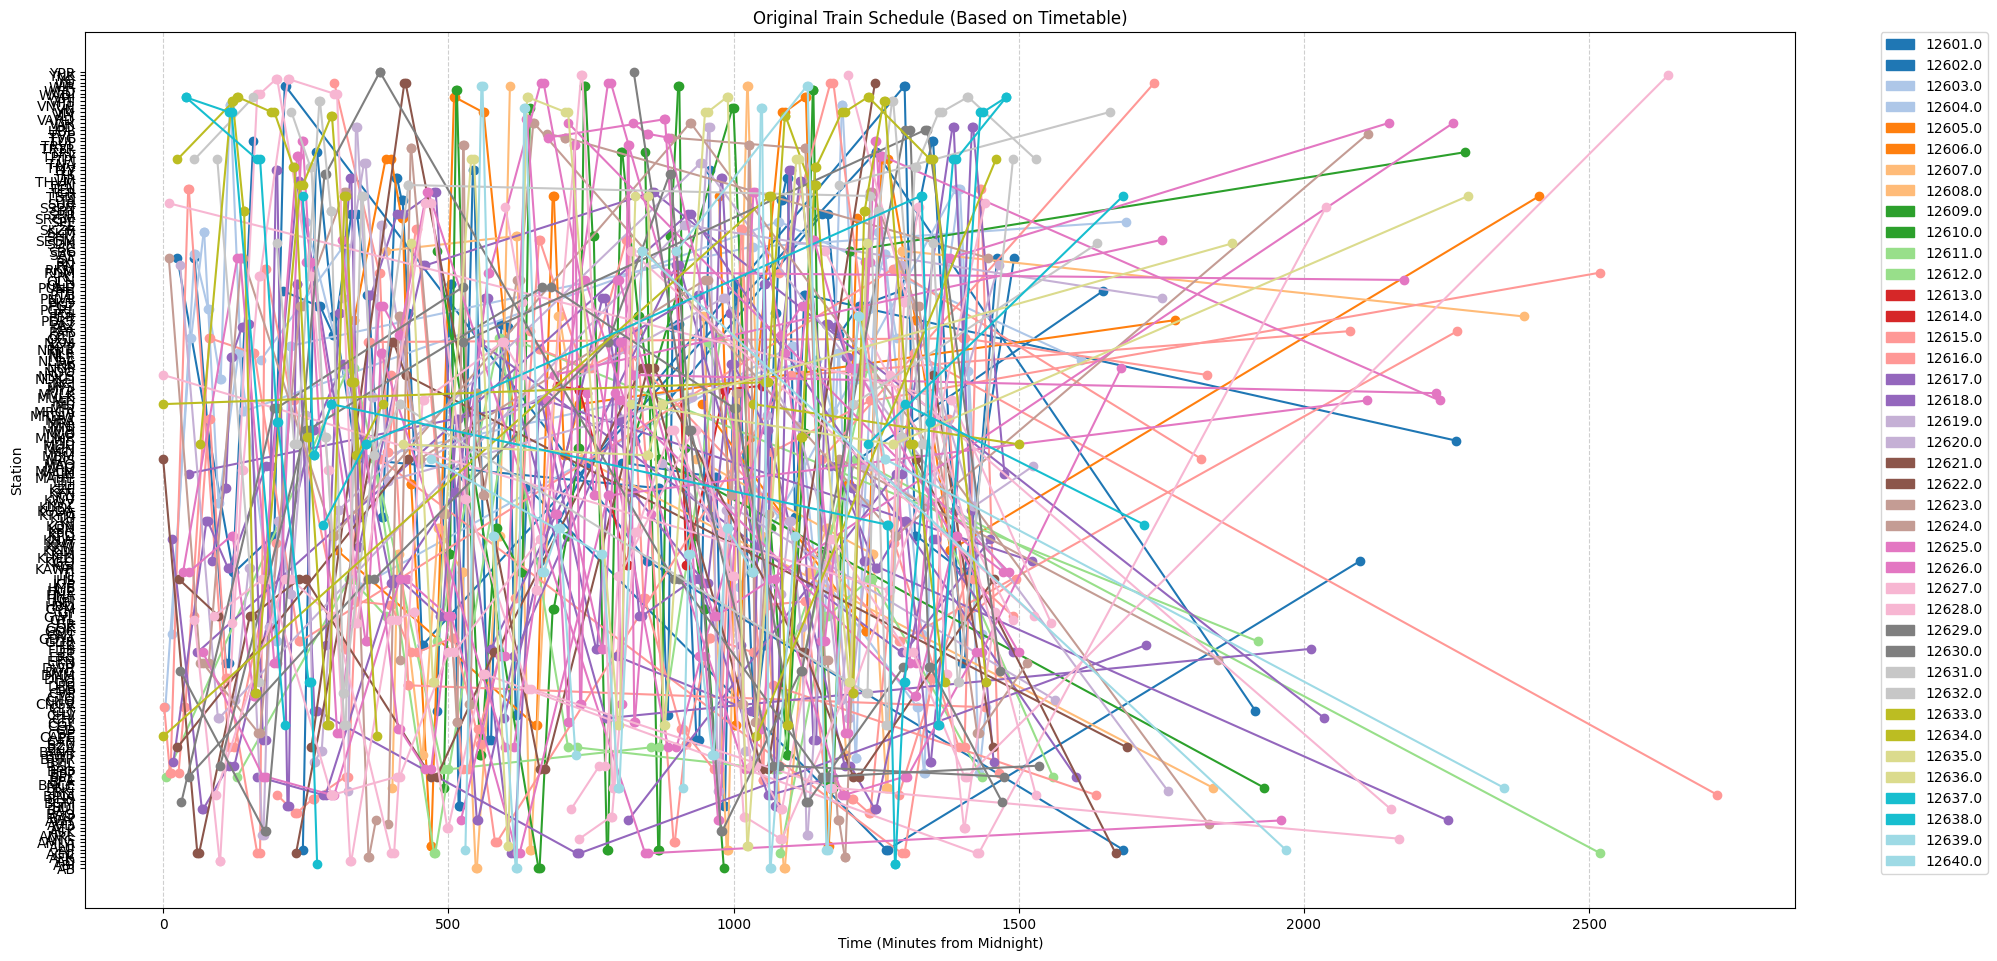

Displaying Optimized Schedule...


/tmp/ipython-input-2125175919.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(schedule_data))


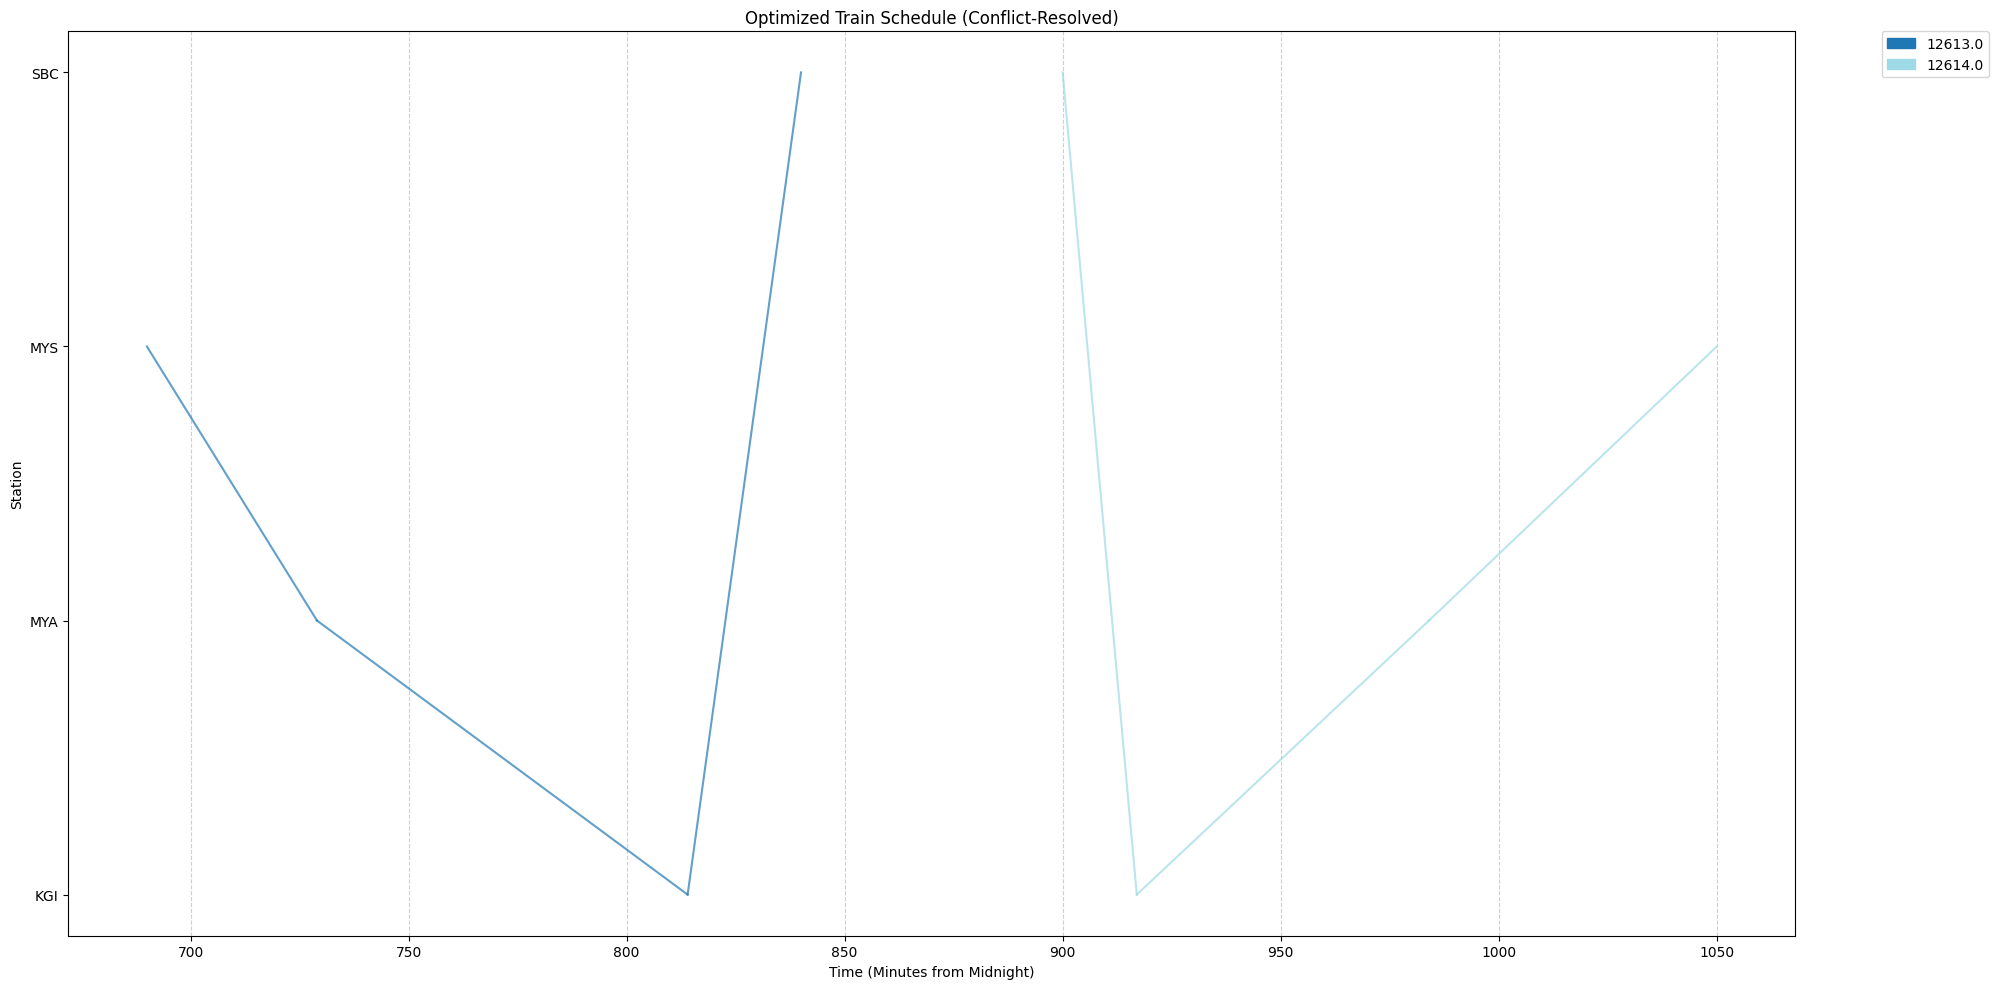

In [6]:
# (Keep all your previous functions like load_train_data, build_time_expanded_graph, etc.)

class GreedyScheduler:
    def __init__(self, base_graph):
        self.base_graph = base_graph
        self.optimized_schedule = {}
        self.occupied_nodes = set()

    def find_and_reserve_path(self, train_id, source_station, dest_station, earliest_start_time, segment_duration, subgraph):
        """
        Finds the first conflict-free path within a smaller, relevant subgraph.
        """
        current_start_time = earliest_start_time

        while True:
            target_arrival_time = current_start_time + segment_duration

            source_node = (source_station, current_start_time)
            target_node = (dest_station, target_arrival_time)

            # Check if nodes exist in the subgraph, not the base_graph
            if source_node not in subgraph or target_node not in subgraph:
                # If we've delayed past the subgraph's time window, we've failed
                # This indicates a major scheduling issue (gridlock)
                return None

            try:
                path = nx.astar_path(subgraph, source_node, target_node, weight='weight')

                is_conflict = any(node in self.occupied_nodes for node in path)

                if is_conflict:
                    current_start_time += 1 # Delay by 1 minute and retry
                    continue
                else:
                    for node in path:
                        self.occupied_nodes.add(node)
                    return path

            except nx.NetworkXNoPath:
                current_start_time += 1 # Delay by 1 minute
                if current_start_time > earliest_start_time + 120: # Safety break: max 2hr delay
                    return None

    def schedule_all_trains(self, train_data):
        """Schedules all trains using the subgraph optimization method."""
        sorted_train_ids = sorted(train_data.keys(), key=lambda t: time_to_minutes(train_data[t]['route'][0]['departure_time']))

        for train_id in sorted_train_ids:
            print(f"Scheduling train {train_id}...")
            # Ensure the route is sorted by original departure time
            route = sorted(train_data[train_id]['route'], key=lambda x: (time_to_minutes(x['departure_time']) + 1440 if time_to_minutes(x['departure_time']) < 240 else time_to_minutes(x['departure_time'])))

            full_train_path = []
            departure_time = time_to_minutes(route[0]['departure_time'])

            for i in range(len(route) - 1):
                source_stop = route[i]
                dest_stop = route[i+1]
                source_station = source_stop['station_code']
                dest_station = dest_stop['station_code']

                # Calculate segment details from the original schedule
                original_start = time_to_minutes(source_stop['departure_time'])
                original_arrival = time_to_minutes(dest_stop['arrival_time'])
                if original_arrival < original_start:
                    original_arrival += 24*60

                segment_duration = original_arrival - original_start

                # --- The Optimization: Create a relevant subgraph ---
                time_window_start = departure_time
                time_window_end = departure_time + segment_duration + 180 # Add 3hr buffer for delays

                nodes_in_window = {
                    n for n, attr in self.base_graph.nodes(data=True)
                    if (n[0] in [source_station, dest_station]) and (time_window_start <= n[1] <= time_window_end)
                }
                subgraph = self.base_graph.subgraph(nodes_in_window)
                # --- End of Optimization ---

                segment_path = self.find_and_reserve_path(train_id, source_station, dest_station, departure_time, segment_duration, subgraph)

                if segment_path:
                    if not full_train_path:
                        full_train_path.extend(segment_path)
                    else:
                        full_train_path.extend(segment_path[1:])

                    departure_time = segment_path[-1][1]
                else:
                    print(f"  - FAILED to schedule segment for {train_id}: {source_station} -> {dest_station}")
                    full_train_path = None
                    break

            if full_train_path:
                self.optimized_schedule[train_id] = full_train_path
                arrival_node = full_train_path[-1]
                original_arrival_final = time_to_minutes(route[-1]['arrival_time'])
                if original_arrival_final < time_to_minutes(route[0]['departure_time']):
                     original_arrival_final += 24*60

                delay = arrival_node[1] - original_arrival_final
                print(f"  - Successfully scheduled. Arrival: {minutes_to_time_str(arrival_node[1])} (Delay: {delay} mins)")

        return self.optimized_schedule
# --- Corrected Main Execution Block ---
if __name__ == "__main__":
    # 1. Load Data
    train_data = load_train_data()

    # 2. Build the base graph of all possible movements
    base_graph = build_time_expanded_graph(train_data, time_limit_minutes=2880)

    # 3. Create and run the scheduler
    scheduler = GreedyScheduler(base_graph)
    optimized_schedule = scheduler.schedule_all_trains(train_data)

    # 4. Visualize the results
    if optimized_schedule:
        print("\nDisplaying Original Schedule...")
        plot_gantt_chart(train_data, "Original Train Schedule (Based on Timetable)", is_original=True)

        print("Displaying Optimized Schedule...")
        plot_gantt_chart(optimized_schedule, "Optimized Train Schedule (Conflict-Resolved)")
    else:
        print("\nCould not generate an optimized schedule.")

In [7]:
def build_time_expanded_graph(train_data):
    """
    Builds a sparse, event-based time-expanded graph.
    Nodes are only created for actual arrival/departure events.
    """
    G = nx.DiGraph()
    station_events = {} # Key: station_code, Value: sorted list of (time, train_id, event_type)

    # 1. Gather all events from the schedule
    for train_id, data in train_data.items():
        for stop in data['route']:
            station = stop['station_code']
            if station not in station_events:
                station_events[station] = []

            arr_time = time_to_minutes(stop['arrival_time'])
            dep_time = time_to_minutes(stop['departure_time'])

            # Handle overnight times by assuming times < 4am are on the next day relative to a ~8pm start
            if arr_time < 240: arr_time += 1440
            if dep_time < 240: dep_time += 1440

            station_events[station].append((arr_time, train_id, 'arr'))
            station_events[station].append((dep_time, train_id, 'dep'))

    # 2. Create nodes and "wait" edges at each station
    for station, events in station_events.items():
        # Sort events chronologically
        events.sort()
        for i in range(len(events) - 1):
            time1, train1, type1 = events[i]
            time2, train2, type2 = events[i+1]
            # Add a generic wait edge allowing any train to wait between scheduled events
            G.add_edge((station, time1), (station, time2), weight=time2 - time1, type='wait')

    # 3. Create "travel" edges between stations
    for train_id, data in train_data.items():
        route = data['route']
        for i in range(len(route) - 1):
            start_stop = route[i]
            end_stop = route[i+1]

            start_station = start_stop['station_code']
            end_station = end_stop['station_code']

            start_time = time_to_minutes(start_stop['departure_time'])
            end_time = time_to_minutes(end_stop['arrival_time'])

            if start_time < 240: start_time += 1440
            if end_time < 240: end_time += 1440
            if end_time < start_time: end_time += 1440

            duration = end_time - start_time
            if duration >= 0:
                G.add_edge(
                    (start_station, start_time),
                    (end_station, end_time),
                    weight=duration,
                    type='travel',
                    train=train_id
                )
    print(f"Efficient event-based graph built with {G.number_of_nodes()} nodes.")
    return G


class GreedyScheduler:
    def __init__(self, base_graph):
        self.base_graph = base_graph
        self.optimized_schedule = {}
        self.occupied_nodes = set()

    def find_and_reserve_path(self, train_id, source_node, target_node):
        """Finds the first conflict-free path by delaying the start time if needed."""
        current_source_node = source_node

        while True:
            try:
                path = nx.astar_path(self.base_graph, current_source_node, target_node, weight='weight')

                is_conflict = any(node in self.occupied_nodes for node in path)

                if not is_conflict:
                    for node in path:
                        self.occupied_nodes.add(node)
                    return path

                # If conflict, find the next available departure time at the source station
                current_time = current_source_node[1]

                # Get all possible future departure times from the graph
                future_deps = [t for stn, t in self.base_graph.successors(current_source_node) if stn == current_source_node[0] and t > current_time]

                if not future_deps: return None # No future path from this station

                current_source_node = (current_source_node[0], min(future_deps))

            except (nx.NetworkXNoPath, nx.NodeNotFound):
                return None # The destination is truly unreachable

    def schedule_all_trains(self, train_data):
        """Schedules all trains on the efficient event-based graph."""
        # Prioritize trains by their original departure time
        train_list = sorted(train_data.items(), key=lambda item: time_to_minutes(item[1]['route'][0]['departure_time']))

        for train_id, data in train_list:
            print(f"Scheduling train {train_id}...")
            route = data['route']

            # Define the full journey's start and end nodes from the timetable
            start_stop = route[0]
            end_stop = route[-1]

            start_time = time_to_minutes(start_stop['departure_time'])
            end_time = time_to_minutes(end_stop['arrival_time'])

            if start_time < 240: start_time += 1440
            if end_time < 240: end_time += 1440
            if end_time < start_time: end_time += 1440

            source_node = (start_stop['station_code'], start_time)
            target_node = (end_stop['station_code'], end_time)

            # Find a conflict-free path for the entire journey
            path = self.find_and_reserve_path(train_id, source_node, target_node)

            if path:
                self.optimized_schedule[train_id] = path
                arrival_node = path[-1]
                delay = arrival_node[1] - end_time
                print(f"  - Successfully scheduled. New arrival: {minutes_to_time_str(arrival_node[1])} (Delay: {delay} mins)")
            else:
                print(f"  - FAILED to schedule train {train_id}")

        return self.optimized_schedule


Efficient event-based graph built with 1622 nodes and 2157 edges.
Scheduling train 12606.0...
  - Successfully scheduled. New arrival: 12:10 (Delay: 0 mins)
Scheduling train 12611.0...
  - FAILED to schedule train 12611.0
Scheduling train 12608.0...
  - Successfully scheduled. New arrival: 12:15 (Delay: 0 mins)
Scheduling train 12636.0...
  - Successfully scheduled. New arrival: 14:35 (Delay: 0 mins)
Scheduling train 12639.0...
  - Successfully scheduled. New arrival: 14:00 (Delay: 0 mins)
Scheduling train 12610.0...
  - Successfully scheduled. New arrival: 14:30 (Delay: 0 mins)
Scheduling train 12630.0...
  - FAILED to schedule train 12630.0
Scheduling train 12618.0...
  - FAILED to schedule train 12618.0
Scheduling train 12625.0...
  - FAILED to schedule train 12625.0
Scheduling train 12626.0...
  - FAILED to schedule train 12626.0
Scheduling train 12613.0...
  - FAILED to schedule train 12613.0
Scheduling train 12617.0...
  - FAILED to schedule train 12617.0
Scheduling train 12602.0

/tmp/ipython-input-4132775058.py:200: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(schedule_data))


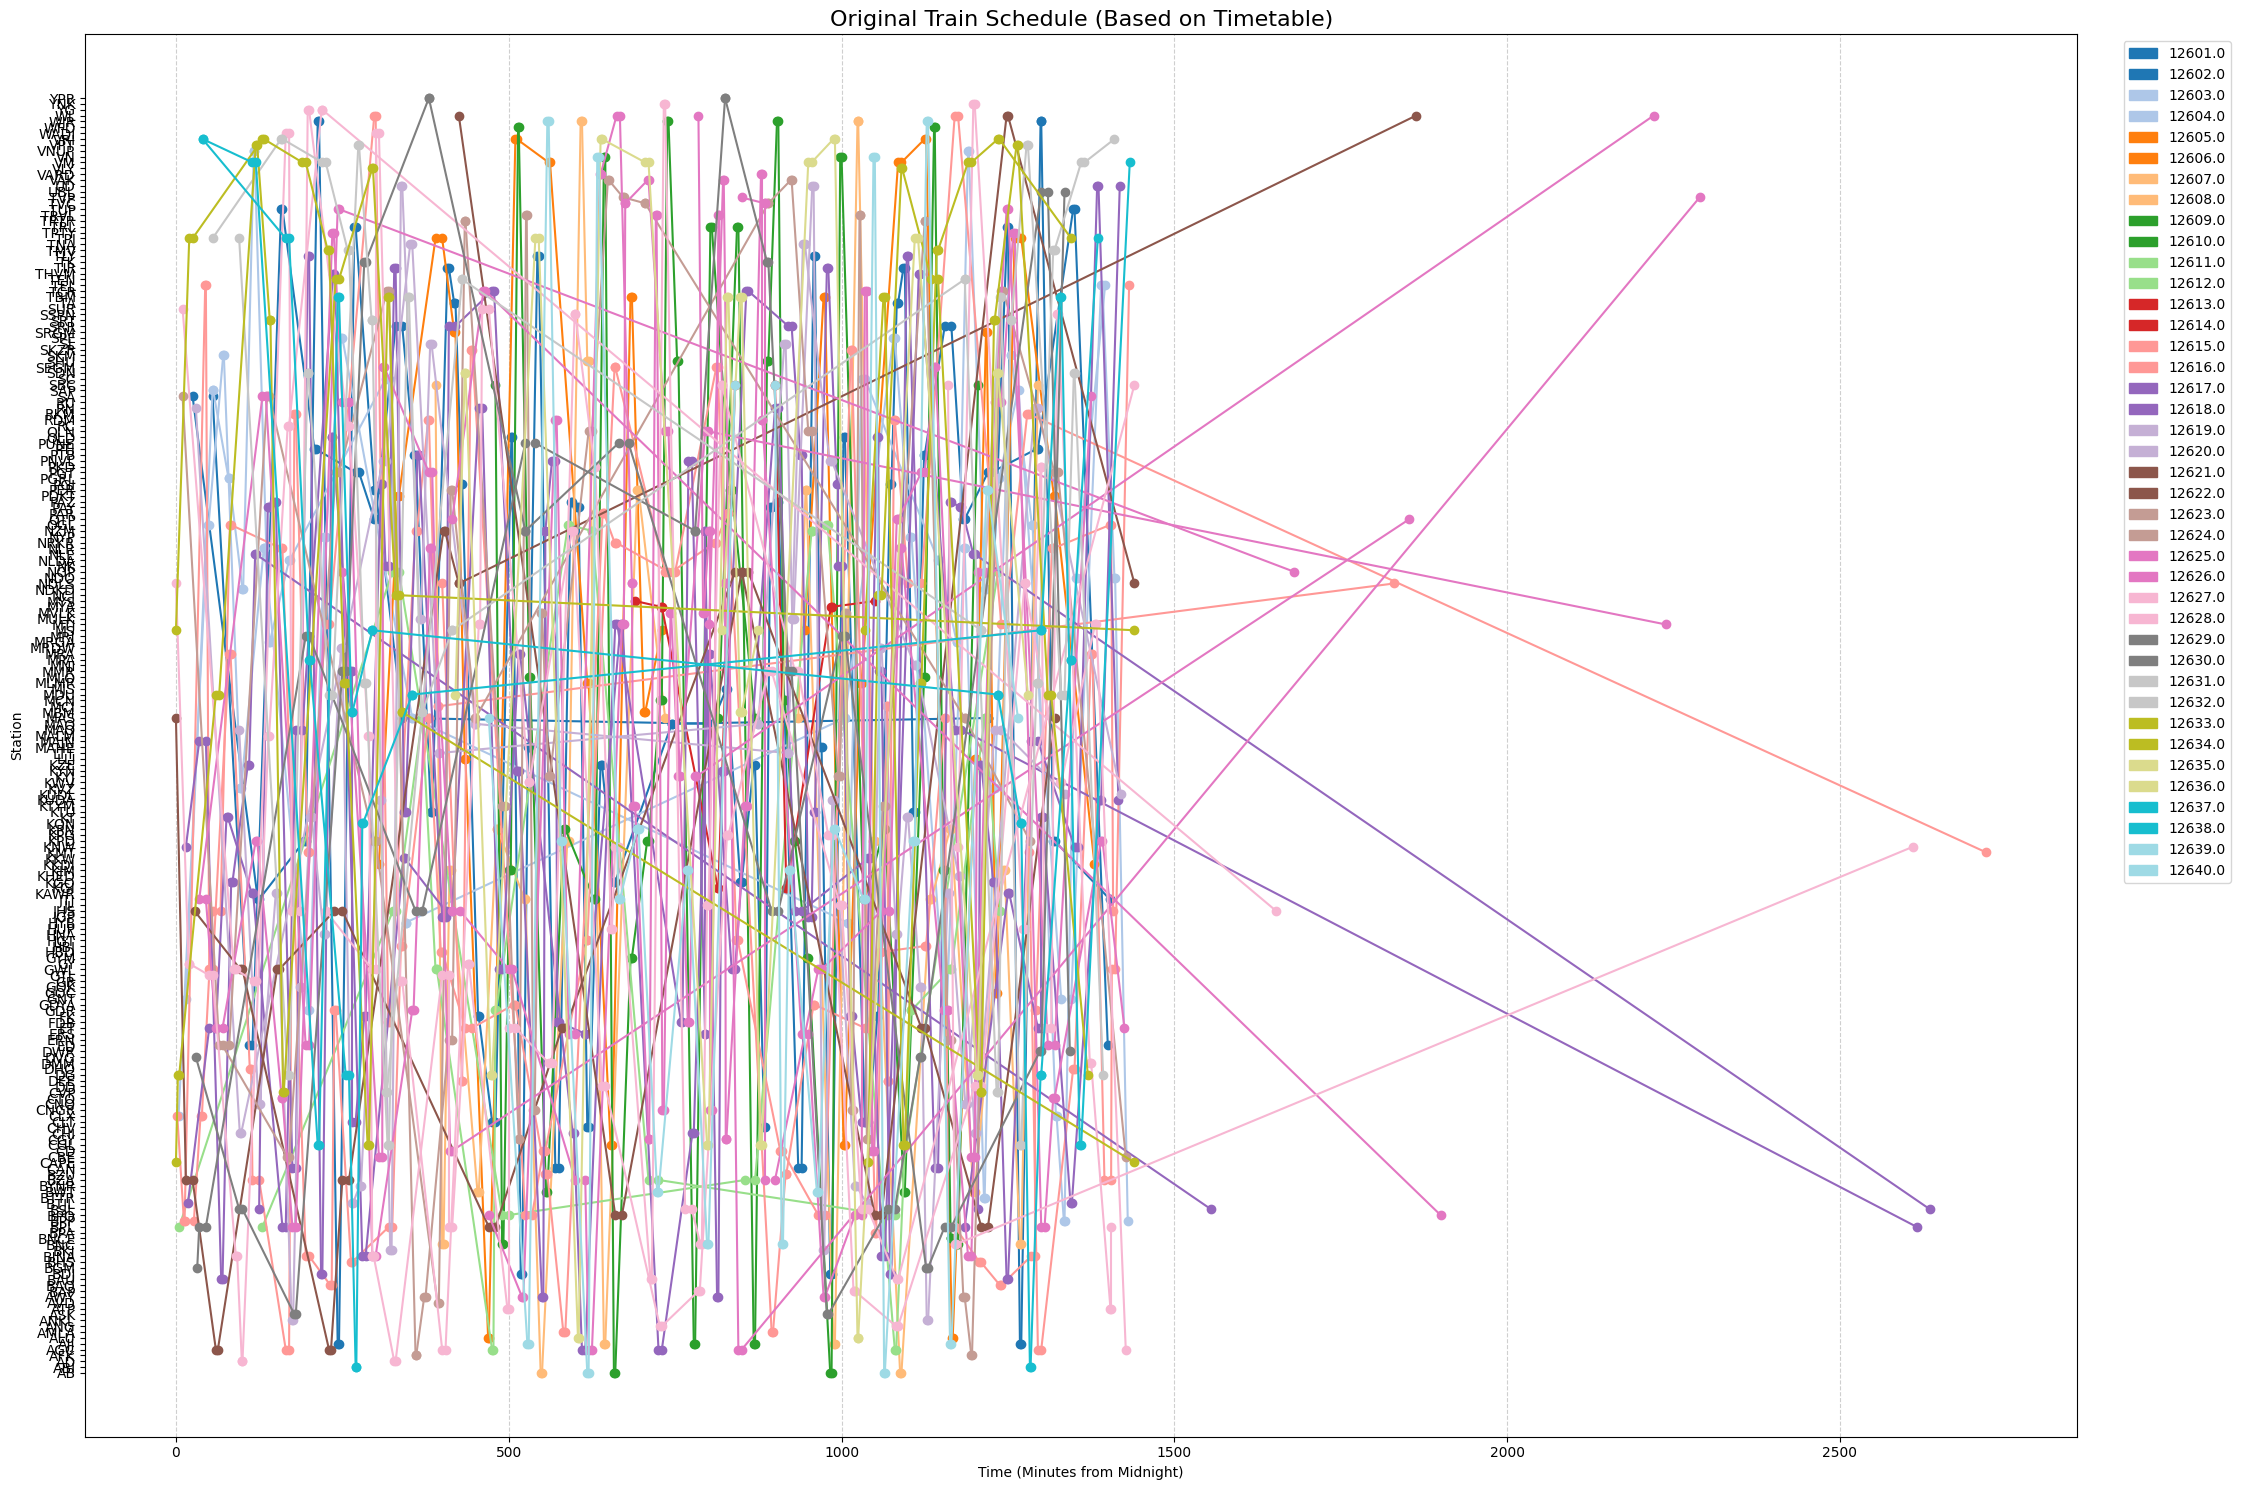


Displaying Optimized Schedule Chart...


/tmp/ipython-input-4132775058.py:200: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(schedule_data))


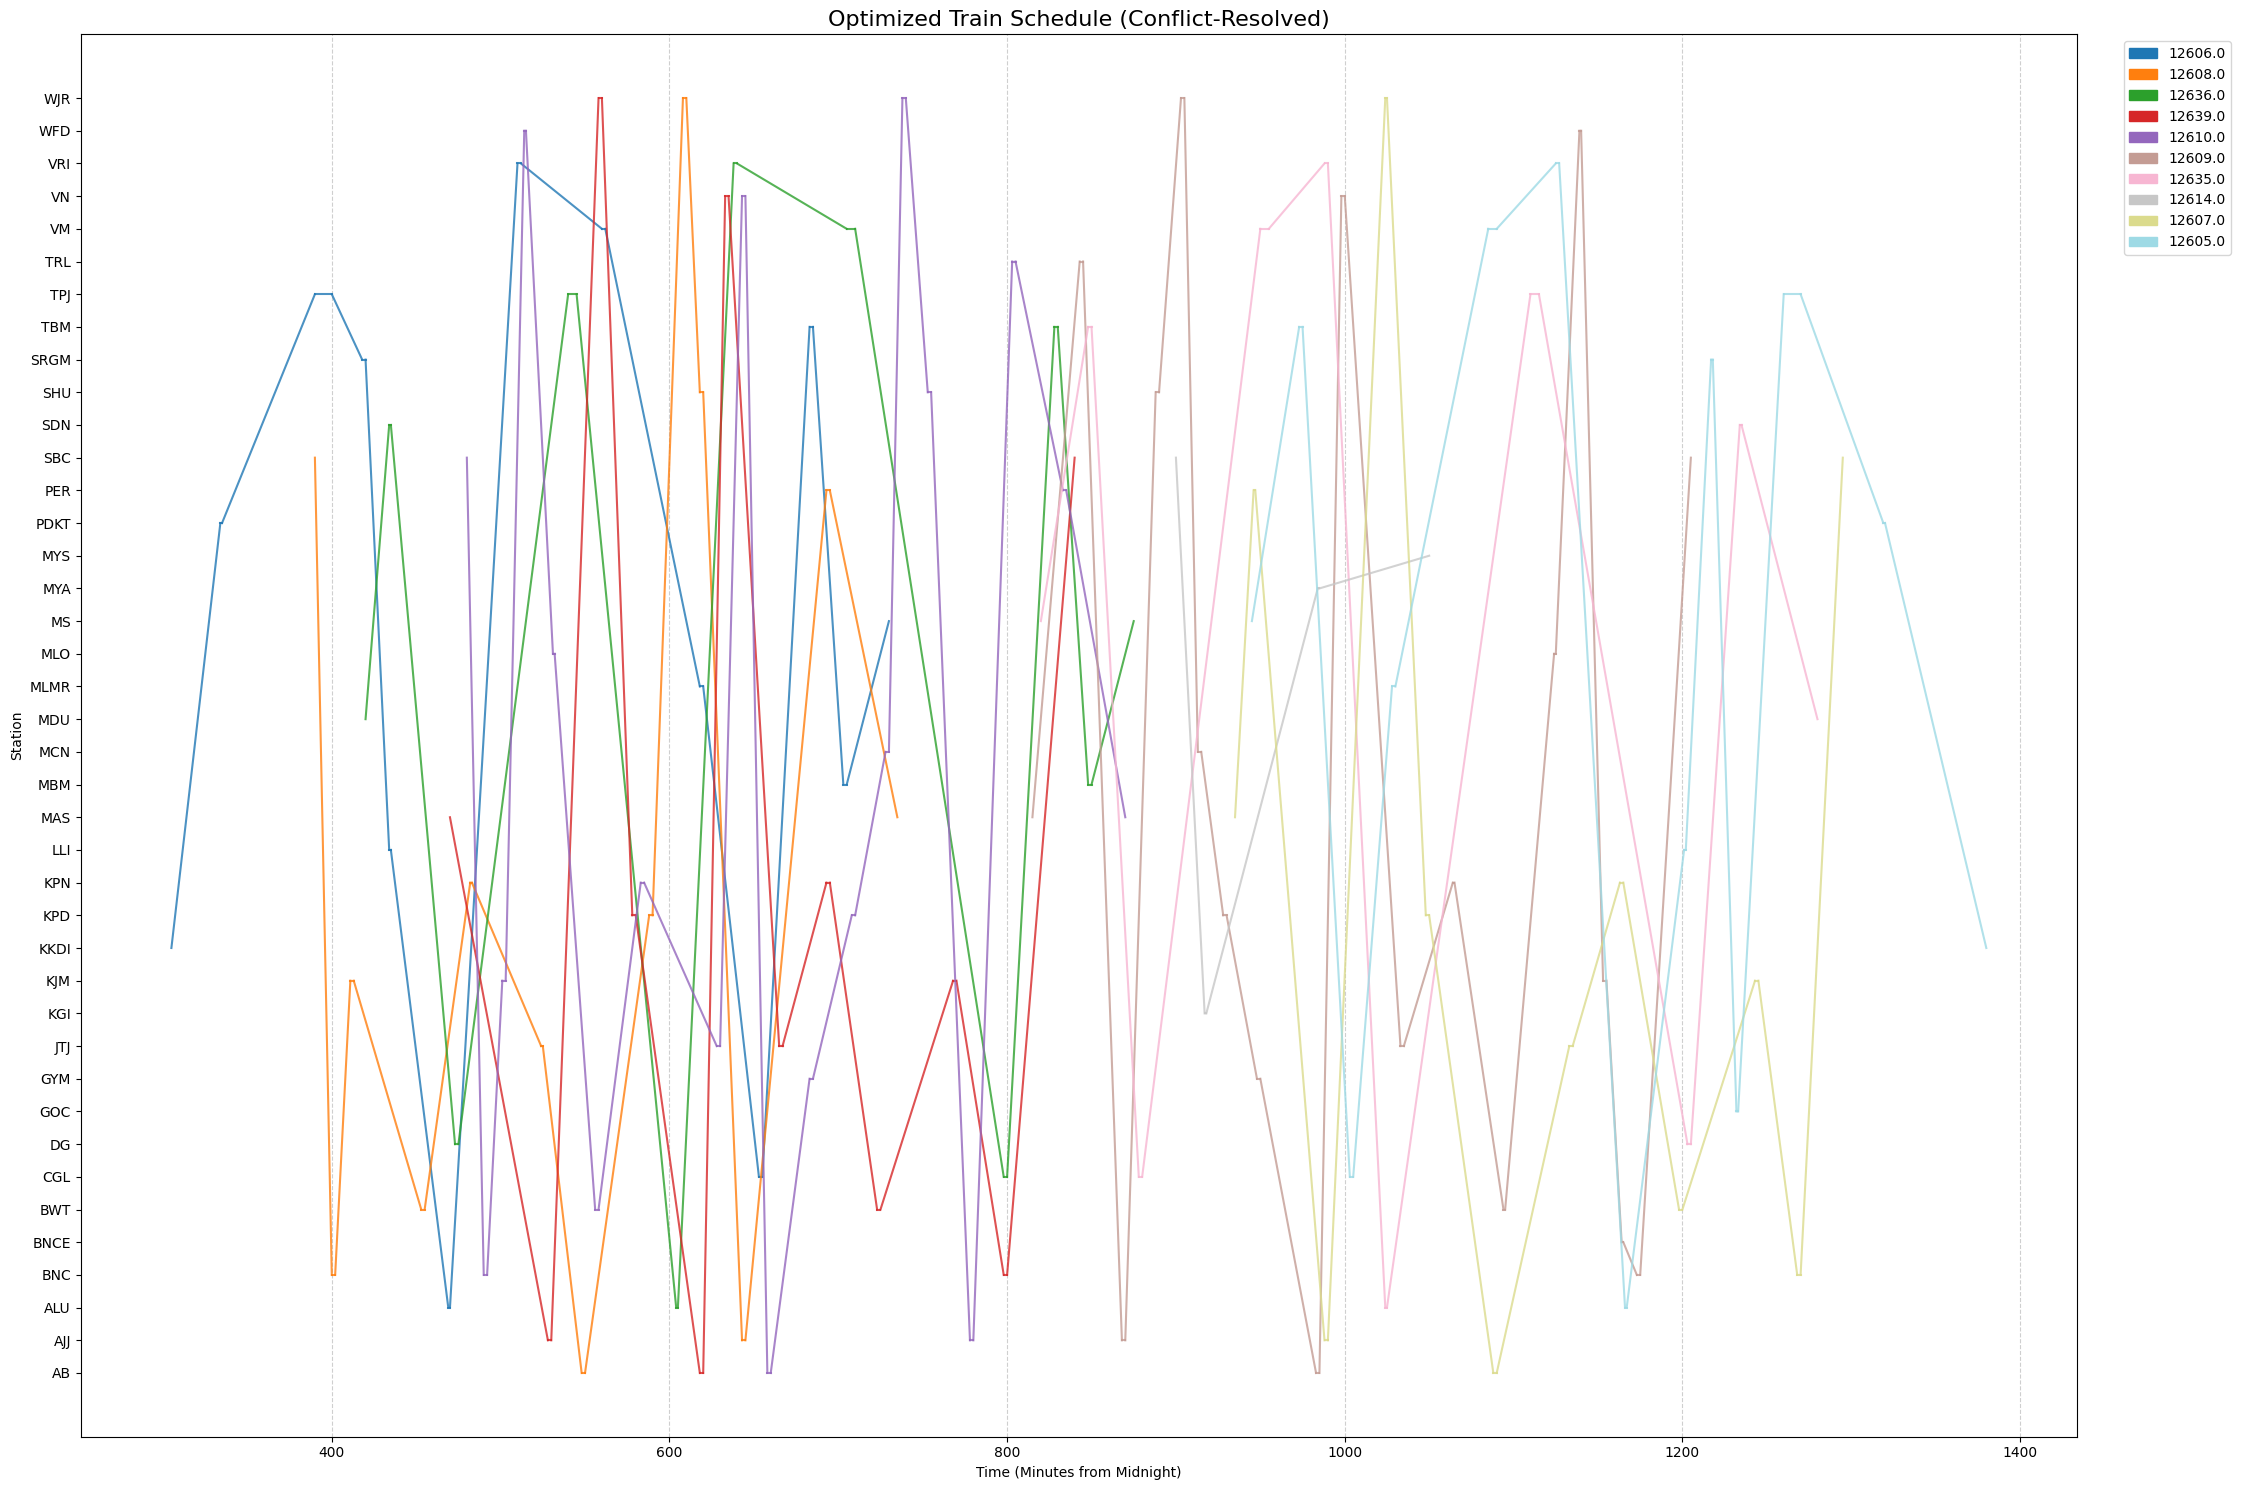

In [8]:
import json
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --------------------------------------------------------------------------
# 1. DATA LOADING AND HELPER FUNCTIONS
# --------------------------------------------------------------------------

def load_train_data(filename="trains_schedule.json"):
    """Loads train schedule data from a JSON file."""
    with open(filename, 'r') as f:
        return json.load(f)

def time_to_minutes(time_str):
    """Converts a 'HH:MM:SS' string to total minutes from midnight."""
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m

def minutes_to_time_str(minutes):
    """Converts total minutes from midnight back to 'HH:MM' string."""
    minutes = int(minutes)
    h = (minutes // 60) % 24
    m = minutes % 60
    return f"{h:02d}:{m:02d}"

# --------------------------------------------------------------------------
# 2. EFFICIENT GRAPH MODELING
# --------------------------------------------------------------------------

def build_time_expanded_graph(train_data):
    """
    Builds a sparse, event-based time-expanded graph.
    Nodes are only created for actual arrival/departure events.
    """
    G = nx.DiGraph()
    station_events = {} # Key: station_code, Value: sorted list of (time, train_id, event_type)

    # 1. Gather all events from the schedule
    for train_id, data in train_data.items():
        for stop in data['route']:
            station = stop['station_code']
            if station not in station_events:
                station_events[station] = []

            arr_time = time_to_minutes(stop['arrival_time'])
            dep_time = time_to_minutes(stop['departure_time'])

            # Handle overnight schedules by treating early morning as "day 2"
            # This is a heuristic that assumes journeys start in the afternoon/evening
            if arr_time < 240: arr_time += 1440
            if dep_time < 240: dep_time += 1440

            station_events[station].append((arr_time, train_id, 'arr'))
            station_events[station].append((dep_time, train_id, 'dep'))

    # 2. Create nodes and "wait" edges at each station
    for station, events in station_events.items():
        # Sort events chronologically to connect them in order
        events.sort()
        for i in range(len(events) - 1):
            time1, _, _ = events[i]
            time2, _, _ = events[i+1]

            if time1 != time2:
                # Add a generic wait edge allowing any train to wait between scheduled events
                G.add_edge((station, time1), (station, time2), weight=time2 - time1, type='wait')

    # 3. Create "travel" edges between stations based on the timetable
    for train_id, data in train_data.items():
        # Sort route by time to ensure correct sequencing
        route = sorted(data['route'], key=lambda x: time_to_minutes(x['departure_time']))
        for i in range(len(route) - 1):
            start_stop = route[i]
            end_stop = route[i+1]

            start_station = start_stop['station_code']
            end_station = end_stop['station_code']

            start_time = time_to_minutes(start_stop['departure_time'])
            end_time = time_to_minutes(end_stop['arrival_time'])

            if start_time < 240: start_time += 1440
            if end_time < 240: end_time += 1440
            if end_time < start_time: end_time += 1440 # Handle overnight travel segments

            duration = end_time - start_time
            if duration >= 0:
                G.add_edge(
                    (start_station, start_time),
                    (end_station, end_time),
                    weight=duration,
                    type='travel',
                    train=train_id
                )
    print(f"Efficient event-based graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

# --------------------------------------------------------------------------
# 3. AI SCHEDULING AGENT
# --------------------------------------------------------------------------

class GreedyScheduler:
    def __init__(self, base_graph):
        self.base_graph = base_graph
        self.optimized_schedule = {}
        self.occupied_nodes = set()

    def find_and_reserve_path(self, train_id, source_node, target_node):
        """Finds the first conflict-free path by delaying the start time if needed."""
        current_source_node = source_node

        while True:
            try:
                # Use a heuristic for A* to prioritize paths that end sooner.
                # Here, we estimate remaining time.
                def heuristic(u, v):
                    return (v[1] - u[1]) * 0.9 # A simple time-based heuristic

                path = nx.astar_path(self.base_graph, current_source_node, target_node, heuristic=heuristic, weight='weight')

                is_conflict = any(node in self.occupied_nodes for node in path)

                if not is_conflict:
                    for node in path:
                        self.occupied_nodes.add(node)
                    return path

                # If conflict, find the next available departure time at the source station
                current_time = current_source_node[1]

                # Get all possible future departure times for this train from the graph
                future_deps = [t for stn, t in self.base_graph.successors(current_source_node) if stn == current_source_node[0] and t > current_time]

                if not future_deps: return None # No future path from this station

                current_source_node = (current_source_node[0], min(future_deps))

            except (nx.NetworkXNoPath, nx.NodeNotFound):
                # This can happen if the target node becomes unreachable after a delay
                return None

    def schedule_all_trains(self, train_data):
        """Schedules all trains on the efficient event-based graph."""
        # Prioritize trains by their original departure time
        train_list = sorted(train_data.items(), key=lambda item: time_to_minutes(item[1]['route'][0]['departure_time']))

        for train_id, data in train_list:
            print(f"Scheduling train {train_id}...")
            route = sorted(data['route'], key=lambda x: time_to_minutes(x['departure_time']))

            # Define the full journey's start and end nodes from the timetable
            start_stop = route[0]
            end_stop = route[-1]

            start_time = time_to_minutes(start_stop['departure_time'])
            end_time = time_to_minutes(end_stop['arrival_time'])

            if start_time < 240: start_time += 1440
            if end_time < 240: end_time += 1440
            if end_time < start_time: end_time += 1440

            source_node = (start_stop['station_code'], start_time)
            target_node = (end_stop['station_code'], end_time)

            path = self.find_and_reserve_path(train_id, source_node, target_node)

            if path:
                self.optimized_schedule[train_id] = path
                arrival_node = path[-1]
                delay = arrival_node[1] - end_time
                print(f"  - Successfully scheduled. New arrival: {minutes_to_time_str(arrival_node[1])} (Delay: {delay} mins)")
            else:
                print(f"  - FAILED to schedule train {train_id}")

        return self.optimized_schedule

# --------------------------------------------------------------------------
# 4. VISUALIZATION
# --------------------------------------------------------------------------

def plot_gantt_chart(schedule_data, title, is_original=False):
    """Plots a Gantt chart of the train schedule."""
    fig, ax = plt.subplots(figsize=(25, 15))

    all_stations = set()
    if is_original:
        for train in schedule_data.values():
            for stop in train.get('route', []):
                all_stations.add(stop['station_code'])
    else:
        for path in schedule_data.values():
            for node in path:
                all_stations.add(node[0])

    sorted_stations = sorted(list(all_stations))
    station_y_coords = {station: i for i, station in enumerate(sorted_stations)}

    colors = plt.cm.get_cmap('tab20', len(schedule_data))
    train_colors = {train_id: colors(i) for i, train_id in enumerate(schedule_data.keys())}

    if is_original:
        for train_id, data in schedule_data.items():
            route = sorted(data['route'], key=lambda x: time_to_minutes(x['departure_time']))
            for i in range(len(route) - 1):
                start_stop = route[i]
                end_stop = route[i+1]

                start_station = start_stop['station_code']
                end_station = end_stop['station_code']

                start_time = time_to_minutes(start_stop['departure_time'])
                end_time = time_to_minutes(end_stop['arrival_time'])

                if end_time < start_time: end_time += 1440

                ax.plot([start_time, end_time], [station_y_coords[start_station], station_y_coords[end_station]],
                        color=train_colors[train_id], marker='o', linestyle='-')
    else:
        for train_id, path in schedule_data.items():
            for i in range(len(path) - 1):
                start_node, end_node = path[i], path[i+1]
                ax.plot([start_node[1], end_node[1]], [station_y_coords[start_node[0]], station_y_coords[end_node[0]]],
                        color=train_colors[train_id], alpha=0.8, linestyle='-')

    ax.set_yticks(range(len(sorted_stations)))
    ax.set_yticklabels(sorted_stations)
    ax.set_xlabel("Time (Minutes from Midnight)")
    ax.set_ylabel("Station")
    ax.set_title(title, fontsize=16)
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    patches = [mpatches.Patch(color=color, label=tid) for tid, color in train_colors.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# --------------------------------------------------------------------------
# 5. MAIN EXECUTION BLOCK
# --------------------------------------------------------------------------

if __name__ == "__main__":
    # Step 1: Load the train data from the JSON file
    train_data = load_train_data()

    # Step 2: Build the new, efficient event-based graph
    base_graph = build_time_expanded_graph(train_data)

    # Step 3: Create the scheduler and run the optimization
    scheduler = GreedyScheduler(base_graph)
    optimized_schedule = scheduler.schedule_all_trains(train_data)

    # Step 4: Visualize the original and optimized schedules for comparison
    if optimized_schedule:
        print("\nDisplaying Original Schedule Chart...")
        plot_gantt_chart(train_data, "Original Train Schedule (Based on Timetable)", is_original=True)

        print("\nDisplaying Optimized Schedule Chart...")
        plot_gantt_chart(optimized_schedule, "Optimized Train Schedule (Conflict-Resolved)")
    else:
        print("\nCould not generate an optimized schedule. No charts to display.")

Building efficient event-based graph...
✅ Graph built successfully with 1600 nodes and 2157 edges.
Scheduling train 12606.0...
  - ✅ Successfully scheduled. Final arrival: 12:10 (Total Delay: 0 mins)
Scheduling train 12611.0...
  - ❌ FAILED on segment: MAS -> GWL
  - ❌ FAILED to schedule full journey for train 12611.0
Scheduling train 12608.0...
  - ✅ Successfully scheduled. Final arrival: 12:15 (Total Delay: 0 mins)
Scheduling train 12636.0...
  - ✅ Successfully scheduled. Final arrival: 14:35 (Total Delay: 0 mins)
Scheduling train 12639.0...
  - ✅ Successfully scheduled. Final arrival: 14:00 (Total Delay: 0 mins)
Scheduling train 12610.0...
  - ✅ Successfully scheduled. Final arrival: 14:30 (Total Delay: 0 mins)
Scheduling train 12630.0...
  - ❌ FAILED on segment: YPR -> NZM
  - ❌ FAILED to schedule full journey for train 12630.0
Scheduling train 12618.0...
  - ❌ FAILED on segment: BSL -> PAY
  - ❌ FAILED to schedule full journey for train 12618.0
Scheduling train 12625.0...
  - ❌ FA

/tmp/ipython-input-563767602.py:221: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(train_ids_to_plot))


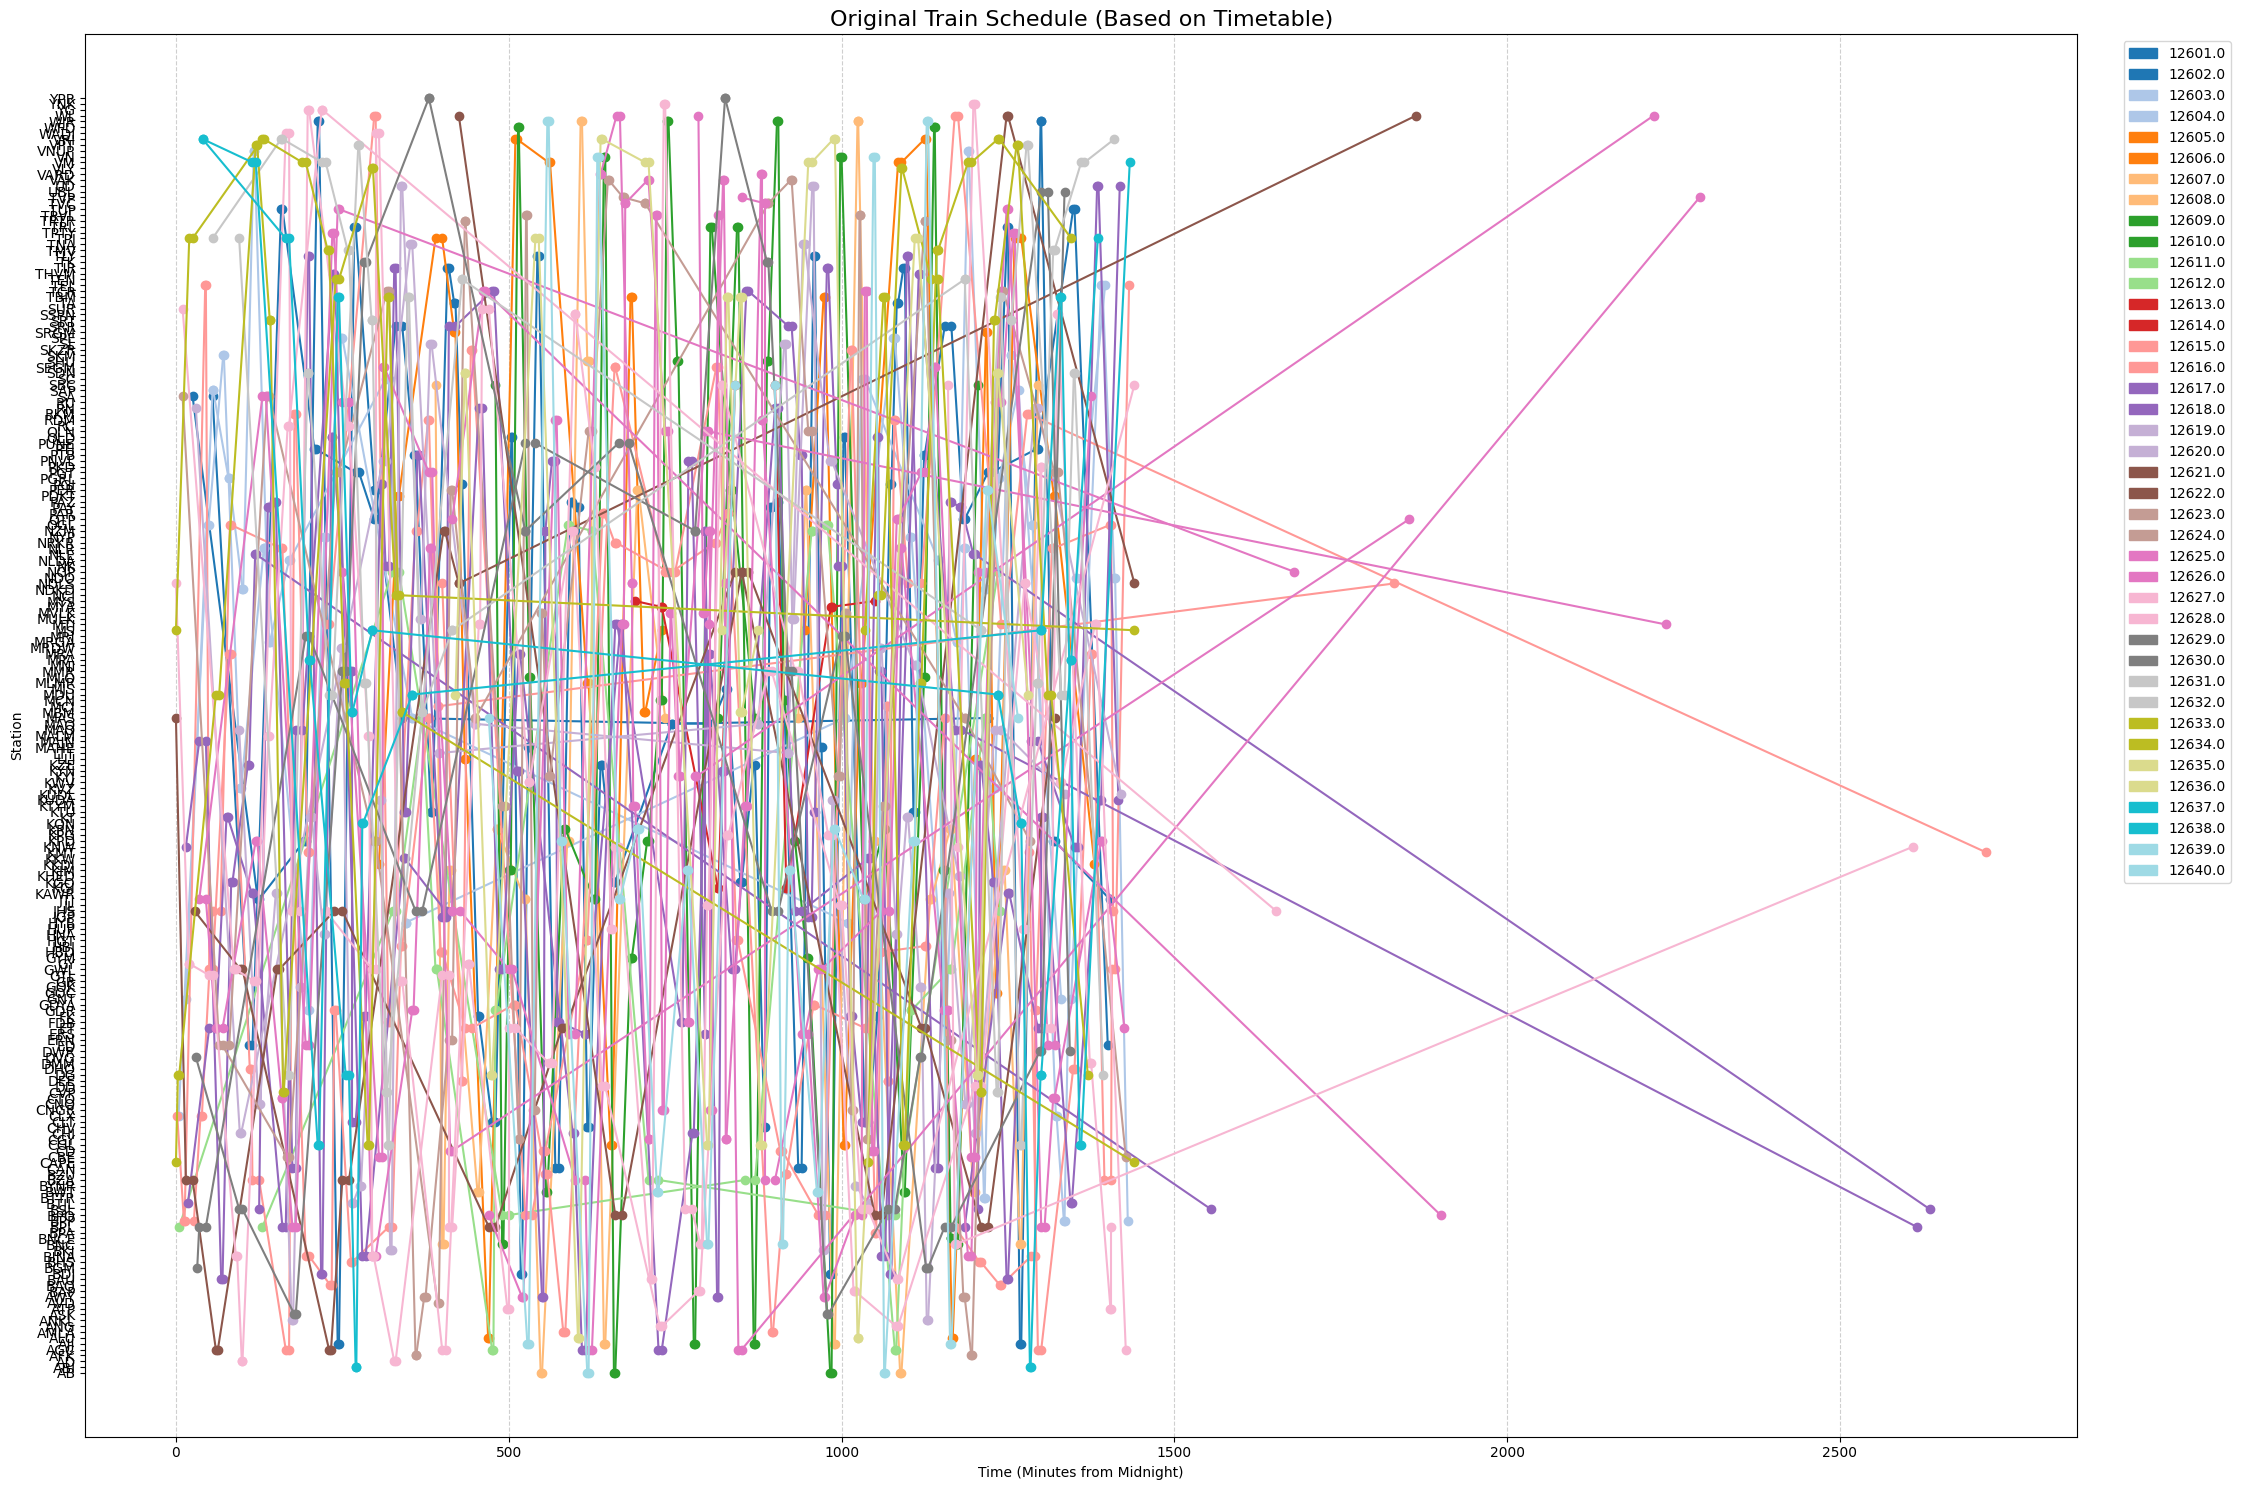

Displaying Optimized Schedule Chart...


/tmp/ipython-input-563767602.py:221: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(train_ids_to_plot))


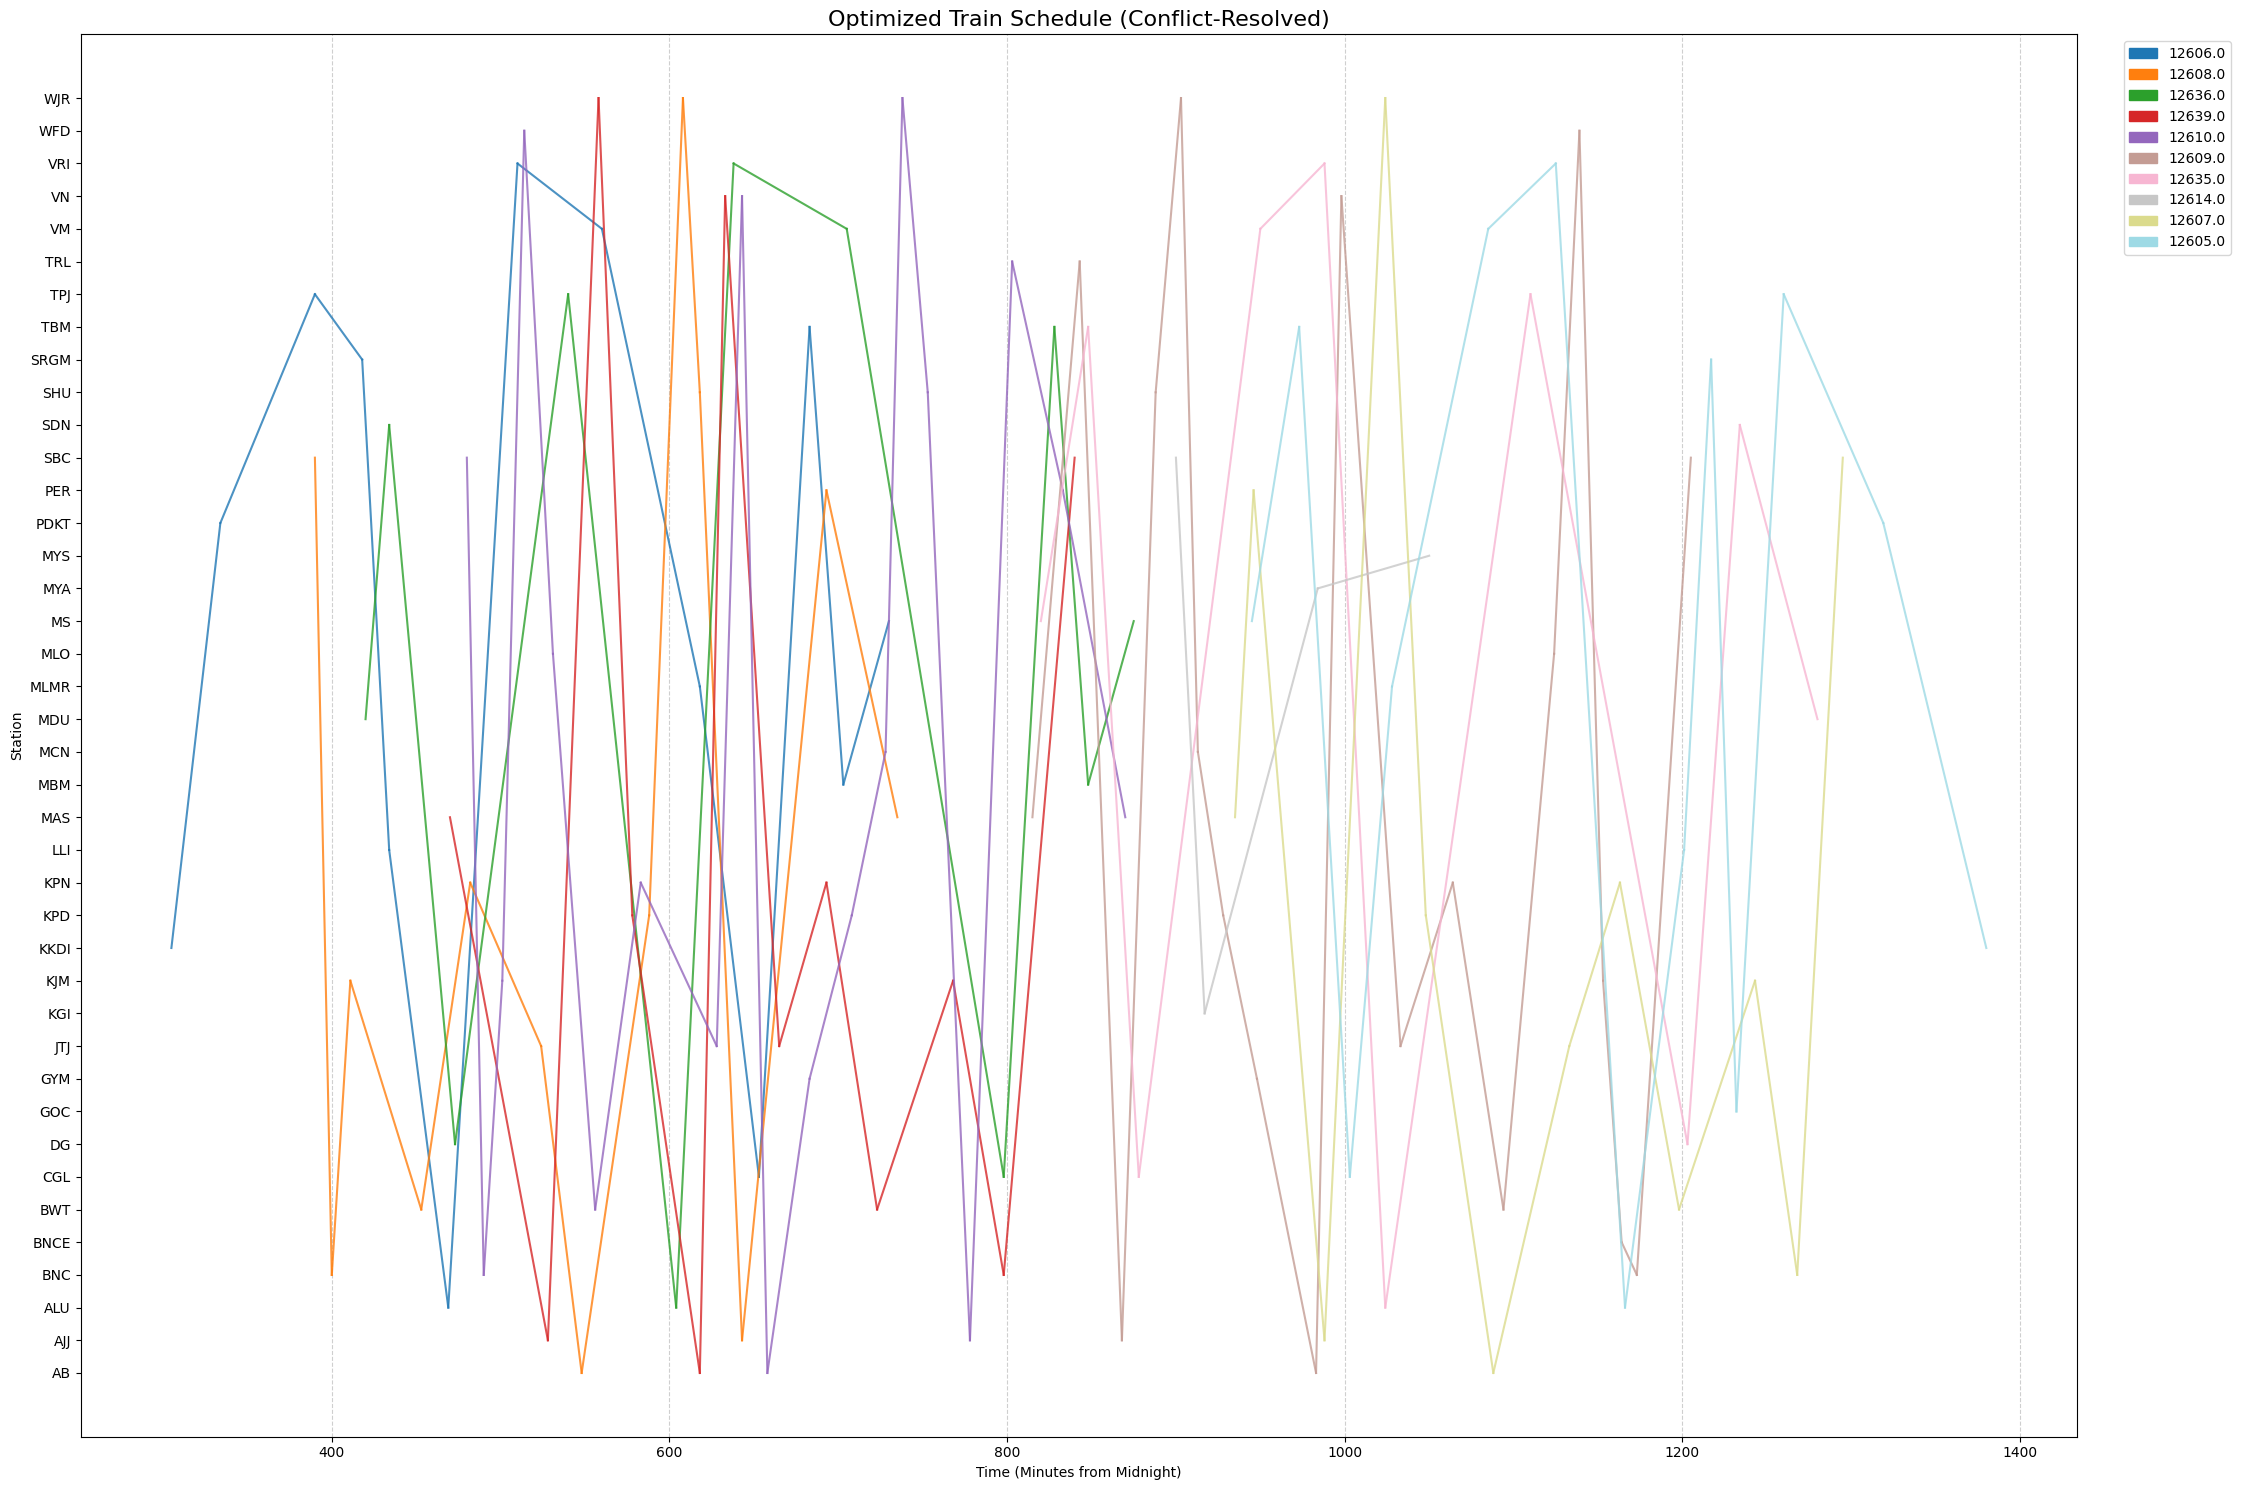

In [9]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --------------------------------------------------------------------------
# 1. DATA LOADING AND HELPER FUNCTIONS
# --------------------------------------------------------------------------

def load_train_data(filename="trains_schedule.json"):
    """Loads train schedule data from a JSON file."""
    with open(filename, 'r') as f:
        return json.load(f)

def time_to_minutes(time_str):
    """Converts a 'HH:MM:SS' string to total minutes from midnight."""
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m

def minutes_to_time_str(minutes):
    """Converts total minutes from midnight back to 'HH:MM' string."""
    if minutes is None: return "N/A"
    minutes = int(minutes)
    h = (minutes // 60) % 24
    m = minutes % 60
    return f"{h:02d}:{m:02d}"

# --------------------------------------------------------------------------
# 2. EFFICIENT GRAPH MODELING
# --------------------------------------------------------------------------

def build_time_expanded_graph(train_data):
    """
    Builds a sparse, event-based time-expanded graph.
    Nodes are only created for actual arrival/departure events.
    """
    print("Building efficient event-based graph...")
    G = nx.DiGraph()
    station_events = {} # Key: station_code, Value: sorted list of times

    # 1. Gather all unique event times at each station
    for train_id, data in train_data.items():
        for stop in data['route']:
            station = stop['station_code']
            if station not in station_events:
                station_events[station] = set()

            arr_time = time_to_minutes(stop['arrival_time'])
            dep_time = time_to_minutes(stop['departure_time'])

            station_events[station].add(arr_time)
            station_events[station].add(dep_time)

    # 2. Create nodes and "wait" edges at each station
    for station, times in station_events.items():
        sorted_times = sorted(list(times))
        for i in range(len(sorted_times) - 1):
            time1 = sorted_times[i]
            time2 = sorted_times[i+1]
            G.add_edge((station, time1), (station, time2), weight=time2 - time1, type='wait')

    # 3. Create "travel" edges between stations based on the timetable
    for train_id, data in train_data.items():
        route = sorted(data['route'], key=lambda x: time_to_minutes(x['departure_time']))
        for i in range(len(route) - 1):
            start_stop = route[i]
            end_stop = route[i+1]

            start_station = start_stop['station_code']
            end_station = end_stop['station_code']

            start_time = time_to_minutes(start_stop['departure_time'])
            end_time = time_to_minutes(end_stop['arrival_time'])

            if end_time < start_time: end_time += 1440 # Handle overnight travel

            duration = end_time - start_time
            if duration >= 0:
                G.add_edge(
                    (start_station, start_time),
                    (end_station, end_time),
                    weight=duration,
                    type='travel',
                    train=train_id
                )
    print(f"✅ Graph built successfully with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

# --------------------------------------------------------------------------
# 3. AI SCHEDULING AGENT
# --------------------------------------------------------------------------

class GreedyScheduler:
    def __init__(self, base_graph):
        self.base_graph = base_graph
        self.optimized_schedule = {}
        self.occupied_nodes = {} # Key: node, Value: train_id

    def find_path_for_segment(self, train_id, source_station, dest_station, earliest_start_time, segment_duration):
        """Finds the first conflict-free path for a single segment, delaying if necessary."""
        current_start_time = earliest_start_time

        while True:
            target_arrival_time = current_start_time + segment_duration

            source_node = (source_station, current_start_time)
            target_node = (dest_station, target_arrival_time)

            if source_node not in self.base_graph:
                # Find the next available time slot at the station if the exact start node isn't available
                possible_next_times = [t for st, t in self.base_graph.nodes() if st == source_station and t >= current_start_time]
                if not possible_next_times: return None
                current_start_time = min(possible_next_times)
                source_node = (source_station, current_start_time)

            try:
                # We need a flexible target, find the earliest arrival at the destination station
                # by searching from our current source node.
                lengths = nx.single_source_dijkstra_path_length(self.base_graph, source_node)

                # Filter for paths that end at the destination station
                possible_arrivals = {node: length for node, length in lengths.items() if node[0] == dest_station}
                if not possible_arrivals: return None

                # Find the earliest possible arrival time and corresponding node
                earliest_arrival_node = min(possible_arrivals, key=lambda n: n[1])
                path = nx.dijkstra_path(self.base_graph, source_node, earliest_arrival_node)

                # Check for conflicts
                is_conflict = any(node in self.occupied_nodes for node in path)

                if not is_conflict:
                    for node in path: self.occupied_nodes[node] = train_id
                    return path

                # If conflict, delay and try again
                current_start_time += 1

            except (nx.NetworkXNoPath, nx.NodeNotFound):
                # If no path exists, even with Dijkstra, then it's impossible from this state
                return None

    def schedule_all_trains(self, train_data):
        """Schedules all trains segment-by-segment to robustly handle delays."""
        train_list = sorted(train_data.items(), key=lambda item: time_to_minutes(item[1]['route'][0]['departure_time']))

        for train_id, data in train_list:
            print(f"Scheduling train {train_id}...")
            route = sorted(data['route'], key=lambda x: time_to_minutes(x['departure_time']))

            full_train_path = []
            current_departure_time = time_to_minutes(route[0]['departure_time'])

            for i in range(len(route) - 1):
                start_stop, end_stop = route[i], route[i+1]

                original_start = time_to_minutes(start_stop['departure_time'])
                original_arrival = time_to_minutes(end_stop['arrival_time'])
                if original_arrival < original_start: original_arrival += 1440
                segment_duration = original_arrival - original_start

                path_segment = self.find_path_for_segment(
                    train_id,
                    start_stop['station_code'],
                    end_stop['station_code'],
                    current_departure_time,
                    segment_duration
                )

                if not path_segment:
                    print(f"  - ❌ FAILED on segment: {start_stop['station_code']} -> {end_stop['station_code']}")
                    full_train_path = None
                    break

                if not full_train_path:
                    full_train_path = path_segment
                else:
                    full_train_path.extend(path_segment[1:])

                current_departure_time = path_segment[-1][1]

            if full_train_path:
                self.optimized_schedule[train_id] = full_train_path
                final_arrival_node = full_train_path[-1]
                original_final_arrival = time_to_minutes(route[-1]['arrival_time'])
                if original_final_arrival < time_to_minutes(route[0]['departure_time']): original_final_arrival += 1440
                delay = final_arrival_node[1] - original_final_arrival
                print(f"  - ✅ Successfully scheduled. Final arrival: {minutes_to_time_str(final_arrival_node[1])} (Total Delay: {delay} mins)")
            else:
                print(f"  - ❌ FAILED to schedule full journey for train {train_id}")

        return self.optimized_schedule

# --------------------------------------------------------------------------
# 4. VISUALIZATION
# --------------------------------------------------------------------------

def plot_gantt_chart(schedule_data, title, is_original=False):
    """Plots a Gantt chart of the train schedule."""
    fig, ax = plt.subplots(figsize=(25, 15))

    all_stations = set()
    train_ids_to_plot = list(schedule_data.keys())

    if is_original:
        for train in schedule_data.values():
            for stop in train.get('route', []):
                all_stations.add(stop['station_code'])
    else:
        for path in schedule_data.values():
            for node in path:
                all_stations.add(node[0])

    if not all_stations:
        print("No data to plot.")
        return

    sorted_stations = sorted(list(all_stations))
    station_y_coords = {station: i for i, station in enumerate(sorted_stations)}

    colors = plt.cm.get_cmap('tab20', len(train_ids_to_plot))
    train_colors = {train_id: colors(i) for i, train_id in enumerate(train_ids_to_plot)}

    if is_original:
        for train_id, data in schedule_data.items():
            route = sorted(data['route'], key=lambda x: time_to_minutes(x['departure_time']))
            for i in range(len(route) - 1):
                start_stop, end_stop = route[i], route[i+1]
                start_time = time_to_minutes(start_stop['departure_time'])
                end_time = time_to_minutes(end_stop['arrival_time'])
                if end_time < start_time: end_time += 1440
                ax.plot([start_time, end_time], [station_y_coords.get(start_stop['station_code']), station_y_coords.get(end_stop['station_code'])],
                        color=train_colors[train_id], marker='o', linestyle='-')
    else:
        for train_id, path in schedule_data.items():
            for i in range(len(path) - 1):
                start_node, end_node = path[i], path[i+1]
                ax.plot([start_node[1], end_node[1]], [station_y_coords.get(start_node[0]), station_y_coords.get(end_node[0])],
                        color=train_colors[train_id], alpha=0.8, linestyle='-')

    ax.set_yticks(range(len(sorted_stations)))
    ax.set_yticklabels(sorted_stations)
    ax.set_xlabel("Time (Minutes from Midnight)")
    ax.set_ylabel("Station")
    ax.set_title(title, fontsize=16)
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    patches = [mpatches.Patch(color=color, label=tid) for tid, color in train_colors.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# --------------------------------------------------------------------------
# 5. MAIN EXECUTION BLOCK
# --------------------------------------------------------------------------

if __name__ == "__main__":
    # Step 1: Load the train data from the JSON file
    train_data = load_train_data()

    # Step 2: Build the new, efficient event-based graph
    base_graph = build_time_expanded_graph(train_data)

    # Step 3: Create the scheduler and run the optimization
    scheduler = GreedyScheduler(base_graph)
    optimized_schedule = scheduler.schedule_all_trains(train_data)

    # Step 4: Visualize the original and optimized schedules for comparison
    print("\n--- Plotting Results ---")
    if train_data:
        print("Displaying Original Schedule Chart...")
        plot_gantt_chart(train_data, "Original Train Schedule (Based on Timetable)", is_original=True)

    if optimized_schedule:
        print("Displaying Optimized Schedule Chart...")
        plot_gantt_chart(optimized_schedule, "Optimized Train Schedule (Conflict-Resolved)")
    else:
        print("Could not generate an optimized schedule. No optimized chart to display.")

Initializing agent-based simulation...
✅ 40 train agents created.
Simulation starting at time: 2 minutes.
  ... Day 1 of simulation complete.
  ... Day 2 of simulation complete.
  ... Day 3 of simulation complete.
  ... Day 4 of simulation complete.
  ... Day 5 of simulation complete.
✅ Simulation finished.
Train 12601.0: Final arrival at 23:23 (Total Delay: 0 mins)
Train 12602.0: Final arrival at 23:20 (Total Delay: 0 mins)
Train 12603.0: Final arrival at 23:16 (Total Delay: 0 mins)
Train 12604.0: Final arrival at 23:50 (Total Delay: 0 mins)
Train 12605.0: Final arrival at 23:00 (Total Delay: 0 mins)
Train 12606.0: Final arrival at 12:10 (Total Delay: 0 mins)
Train 12607.0: Final arrival at 21:35 (Total Delay: 0 mins)
Train 12608.0: Final arrival at 12:15 (Total Delay: 0 mins)
Train 12609.0: Final arrival at 20:05 (Total Delay: 0 mins)
Train 12610.0: Final arrival at 14:30 (Total Delay: 0 mins)
Train 12611.0: Final arrival at 20:35 (Total Delay: 0 mins)
Train 12612.0: Final arrival at

/tmp/ipython-input-433472294.py:149: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(train_ids_to_plot))


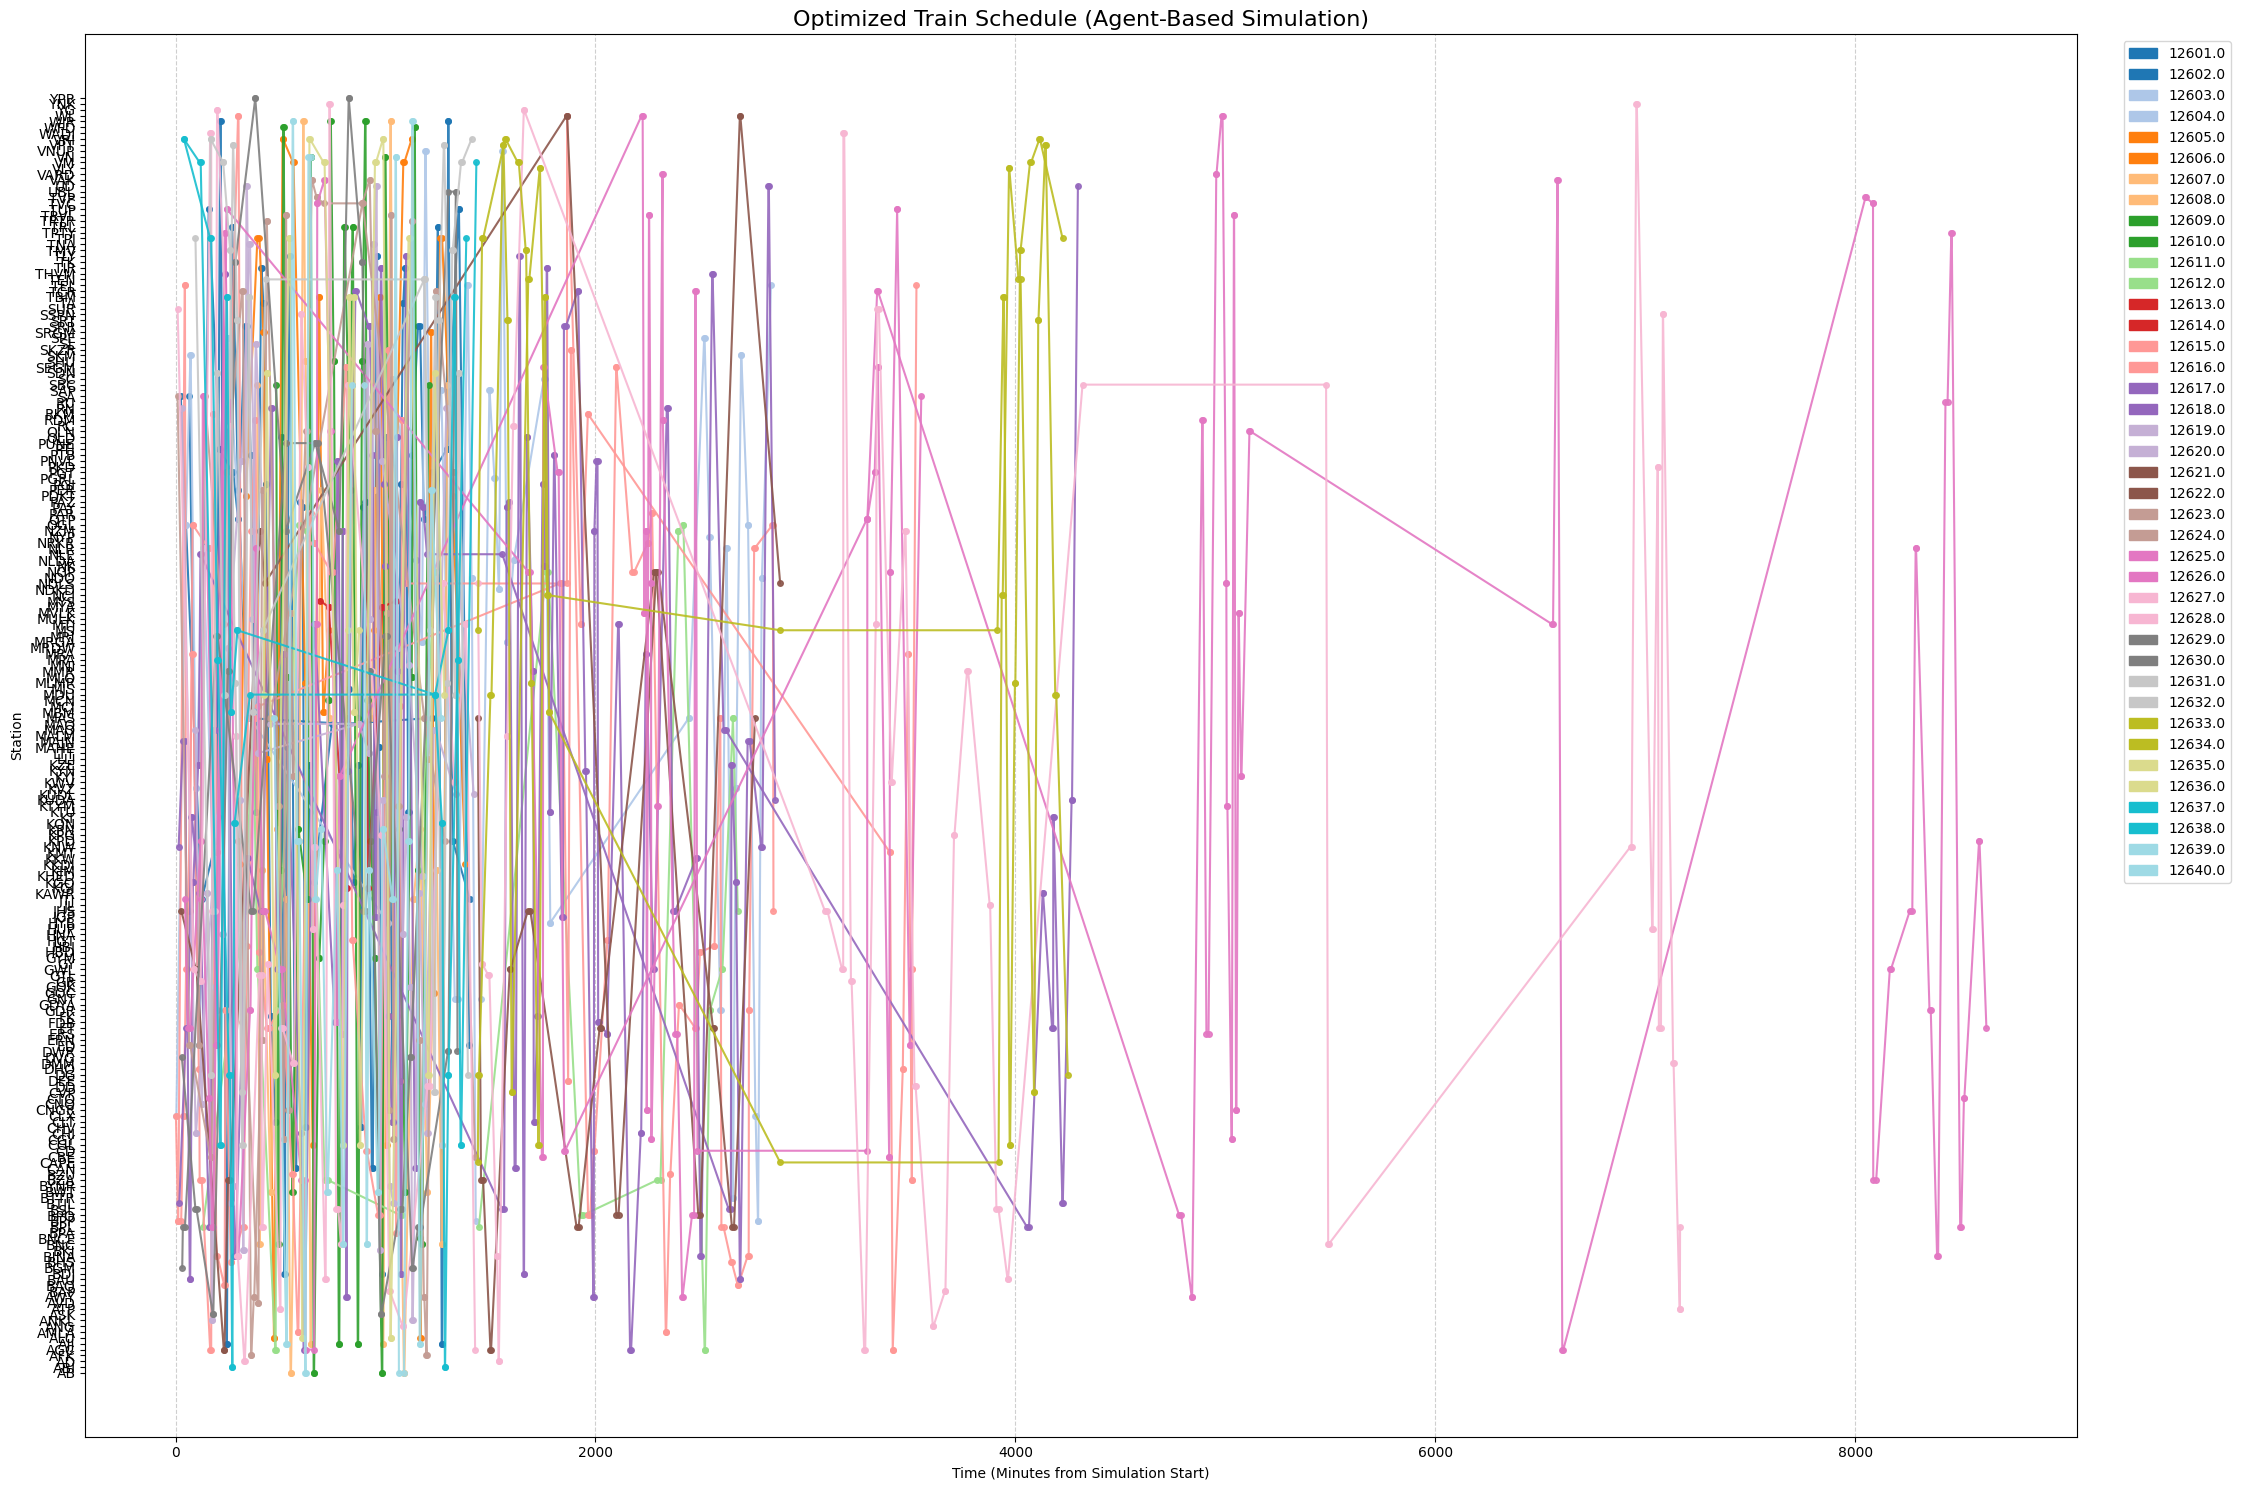

In [11]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --------------------------------------------------------------------------
# 1. HELPER FUNCTIONS & DATA STRUCTURES
# --------------------------------------------------------------------------

def time_to_minutes(time_str):
    """Converts HH:MM:SS to minutes from an epoch (to handle multiple days)."""
    parts = list(map(int, time_str.split(':')))
    return parts[0] * 60 + parts[1]

class TrainAgent:
    """An agent representing a single train with its own state."""
    def __init__(self, train_id, route_data):
        self.id = train_id
        self.route = self._process_route(route_data)
        self.route_index = 0
        self.status = "AT_STATION"  # AT_STATION or IN_TRANSIT
        self.current_station = self.route[0]['station_code']
        self.departure_time = self.route[0]['departure_time']
        self.arrival_time = 0
        self.is_finished = False

    def _process_route(self, route_data):
        """Processes route times to be cumulative from the start of the simulation."""
        processed_route = []
        last_departure = -1
        day_offset = 0
        for stop in sorted(route_data, key=lambda x: time_to_minutes(x['departure_time'])):
            arrival = time_to_minutes(stop['arrival_time'])
            departure = time_to_minutes(stop['departure_time'])

            if arrival < last_departure: day_offset += 1440
            if departure < arrival: day_offset += 1440

            processed_route.append({
                "station_code": stop['station_code'],
                "arrival_time": arrival + day_offset,
                "departure_time": departure + day_offset
            })
            last_departure = departure
        return processed_route

    def log_path(self, time, station):
        """Records the train's position at a given time for later plotting."""
        if not hasattr(self, 'path_log'):
            self.path_log = []
        self.path_log.append({'time': time, 'station': station})

# --------------------------------------------------------------------------
# 2. THE SIMULATION ENGINE
# --------------------------------------------------------------------------

class TrainSimulation:
    def __init__(self, train_data):
        print("Initializing agent-based simulation...")
        self.agents = [TrainAgent(tid, data['route']) for tid, data in train_data.items()]
        self.track_occupancy = {}  # Key: (stn1, stn2), Value: train_id occupying it
        self.master_clock = -1
        print(f"✅ {len(self.agents)} train agents created.")

    def run(self):
        """Runs the entire simulation from start to finish."""
        # Find the first departure time to start the clock
        self.master_clock = min(agent.departure_time for agent in self.agents)
        print(f"Simulation starting at time: {self.master_clock} minutes.")

        while not self._all_agents_finished():
            for agent in self.agents:
                if agent.is_finished:
                    continue

                # --- Handle arrival logic ---
                if agent.status == "IN_TRANSIT" and self.master_clock >= agent.arrival_time:
                    next_stop_info = agent.route[agent.route_index + 1]

                    # Log arrival and free the track
                    agent.log_path(self.master_clock, next_stop_info['station_code'])
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))
                    if self.track_occupancy.get(track) == agent.id:
                        del self.track_occupancy[track]

                    # Update agent state
                    agent.route_index += 1
                    agent.status = "AT_STATION"
                    agent.current_station = next_stop_info['station_code']

                    if agent.route_index == len(agent.route) - 1:
                        agent.is_finished = True
                        continue

                    # Set next departure time
                    agent.departure_time = agent.route[agent.route_index]['departure_time']

                # --- Handle departure logic ---
                if agent.status == "AT_STATION" and self.master_clock >= agent.departure_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))

                    # Check for conflicts
                    if track not in self.track_occupancy:
                        # Occupy the track
                        self.track_occupancy[track] = agent.id
                        agent.status = "IN_TRANSIT"
                        agent.arrival_time = self.master_clock + (next_stop_info['arrival_time'] - agent.departure_time)
                        agent.log_path(self.master_clock, agent.current_station) # Log departure point
                    else:
                        # Conflict! The train must wait. Increment its next departure time.
                        agent.departure_time += 1

            self.master_clock += 1 # Tick the clock
            if self.master_clock % 1440 == 0:
                print(f"  ... Day {self.master_clock // 1440} of simulation complete.")

        print("✅ Simulation finished.")
        return self._collect_results()

    def _all_agents_finished(self):
        return all(agent.is_finished for agent in self.agents)

    def _collect_results(self):
        results = {}
        for agent in self.agents:
            original_end_time = agent.route[-1]['arrival_time']
            actual_end_time = agent.arrival_time
            delay = actual_end_time - original_end_time
            print(f"Train {agent.id}: Final arrival at {minutes_to_time_str(actual_end_time)} (Total Delay: {delay} mins)")
            results[agent.id] = agent.path_log
        return results

# --------------------------------------------------------------------------
# 3. VISUALIZATION
# --------------------------------------------------------------------------

def plot_simulation_results(schedule_data, title):
    fig, ax = plt.subplots(figsize=(25, 15))
    all_stations = set()
    train_ids_to_plot = list(schedule_data.keys())

    for path_log in schedule_data.values():
        for point in path_log:
            all_stations.add(point['station'])

    sorted_stations = sorted(list(all_stations))
    station_y_coords = {station: i for i, station in enumerate(sorted_stations)}

    colors = plt.cm.get_cmap('tab20', len(train_ids_to_plot))
    train_colors = {train_id: colors(i) for i, train_id in enumerate(train_ids_to_plot)}

    for train_id, path_log in schedule_data.items():
        times = [p['time'] for p in path_log]
        stations = [station_y_coords.get(p['station']) for p in path_log]
        ax.plot(times, stations, color=train_colors.get(train_id, 'gray'), alpha=0.9, marker='o', markersize=4, linestyle='-')

    ax.set_yticks(range(len(sorted_stations)))
    ax.set_yticklabels(sorted_stations)
    ax.set_xlabel("Time (Minutes from Simulation Start)")
    ax.set_ylabel("Station")
    ax.set_title(title, fontsize=16)
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    patches = [mpatches.Patch(color=color, label=tid) for tid, color in train_colors.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# --------------------------------------------------------------------------
# 4. MAIN EXECUTION BLOCK
# --------------------------------------------------------------------------

if __name__ == "__main__":
    # Step 1: Load the train data from the JSON file
    with open('trains_schedule.json', 'r') as f:
        train_data = json.load(f)

    # Step 2: Create and run the simulation
    simulation = TrainSimulation(train_data)
    optimized_schedule = simulation.run()

    # Step 3: Visualize the optimized schedule
    print("\n--- Plotting Results ---")
    if optimized_schedule:
        print("Displaying Optimized Schedule Chart...")
        plot_simulation_results(optimized_schedule, "Optimized Train Schedule (Agent-Based Simulation)")
    else:
        print("Simulation did not produce a schedule to plot.")

In [12]:
def plot_zoomed_gantt(schedule_data, title, stations_to_show, time_window):
    """
    Plots a focused Gantt chart for a specific set of stations and a time window.

    Args:
        schedule_data (dict): The simulation output.
        title (str): The chart title.
        stations_to_show (list): A list of station codes to include on the Y-axis.
        time_window (tuple): A (start_minute, end_minute) tuple for the X-axis.
    """
    fig, ax = plt.subplots(figsize=(20, 10))

    # Filter trains that pass through the selected stations
    trains_in_section = {}
    for train_id, path_log in schedule_data.items():
        if any(p['station'] in stations_to_show for p in path_log):
            trains_in_section[train_id] = path_log

    station_y_coords = {station: i for i, station in enumerate(stations_to_show)}
    colors = plt.cm.get_cmap('tab20', len(trains_in_section))
    train_colors = {train_id: colors(i) for i, train_id in enumerate(trains_in_section.keys())}

    for train_id, path_log in trains_in_section.items():
        times = [p['time'] for p in path_log if time_window[0] <= p['time'] <= time_window[1]]
        stations = [station_y_coords.get(p['station']) for p in path_log if time_window[0] <= p['time'] <= time_window[1] and p['station'] in stations_to_show]

        # Ensure we only plot segments where both start and end are in the view
        clean_times, clean_stations = [], []
        for i in range(len(times)):
            if stations[i] is not None:
                clean_times.append(times[i])
                clean_stations.append(stations[i])

        if len(clean_times) > 1:
            ax.plot(clean_times, clean_stations, color=train_colors.get(train_id, 'gray'), alpha=0.9, marker='o', markersize=5, linestyle='-')

    ax.set_yticks(range(len(stations_to_show)))
    ax.set_yticklabels(stations_to_show)
    ax.set_xlabel("Time (Minutes from Simulation Start)")
    ax.set_ylabel("Station")
    ax.set_title(title, fontsize=16)
    ax.set_xlim(time_window)
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    patches = [mpatches.Patch(color=color, label=tid) for tid, color in train_colors.items()]
    ax.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

Initializing agent-based simulation...
✅ 40 train agents created.
Simulation starting at time: 0 minutes.
  ... Day 1 of simulation complete.
  ... Day 2 of simulation complete.
  ... Day 3 of simulation complete.
  ... Day 4 of simulation complete.
  ... Day 5 of simulation complete.
✅ Simulation finished.
Train 12601.0: Final arrival (Total Delay: 0 mins)
Train 12602.0: Final arrival (Total Delay: 0 mins)
Train 12603.0: Final arrival (Total Delay: 0 mins)
Train 12604.0: Final arrival (Total Delay: 0 mins)
Train 12605.0: Final arrival (Total Delay: 0 mins)
Train 12606.0: Final arrival (Total Delay: 0 mins)
Train 12607.0: Final arrival (Total Delay: 0 mins)
Train 12608.0: Final arrival (Total Delay: 0 mins)
Train 12609.0: Final arrival (Total Delay: 0 mins)
Train 12610.0: Final arrival (Total Delay: 0 mins)
Train 12611.0: Final arrival (Total Delay: 0 mins)
Train 12612.0: Final arrival (Total Delay: 0 mins)
Train 12613.0: Final arrival (Total Delay: 0 mins)
Train 12614.0: Final arrival

/tmp/ipython-input-2656442644.py:152: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(trains_in_section))


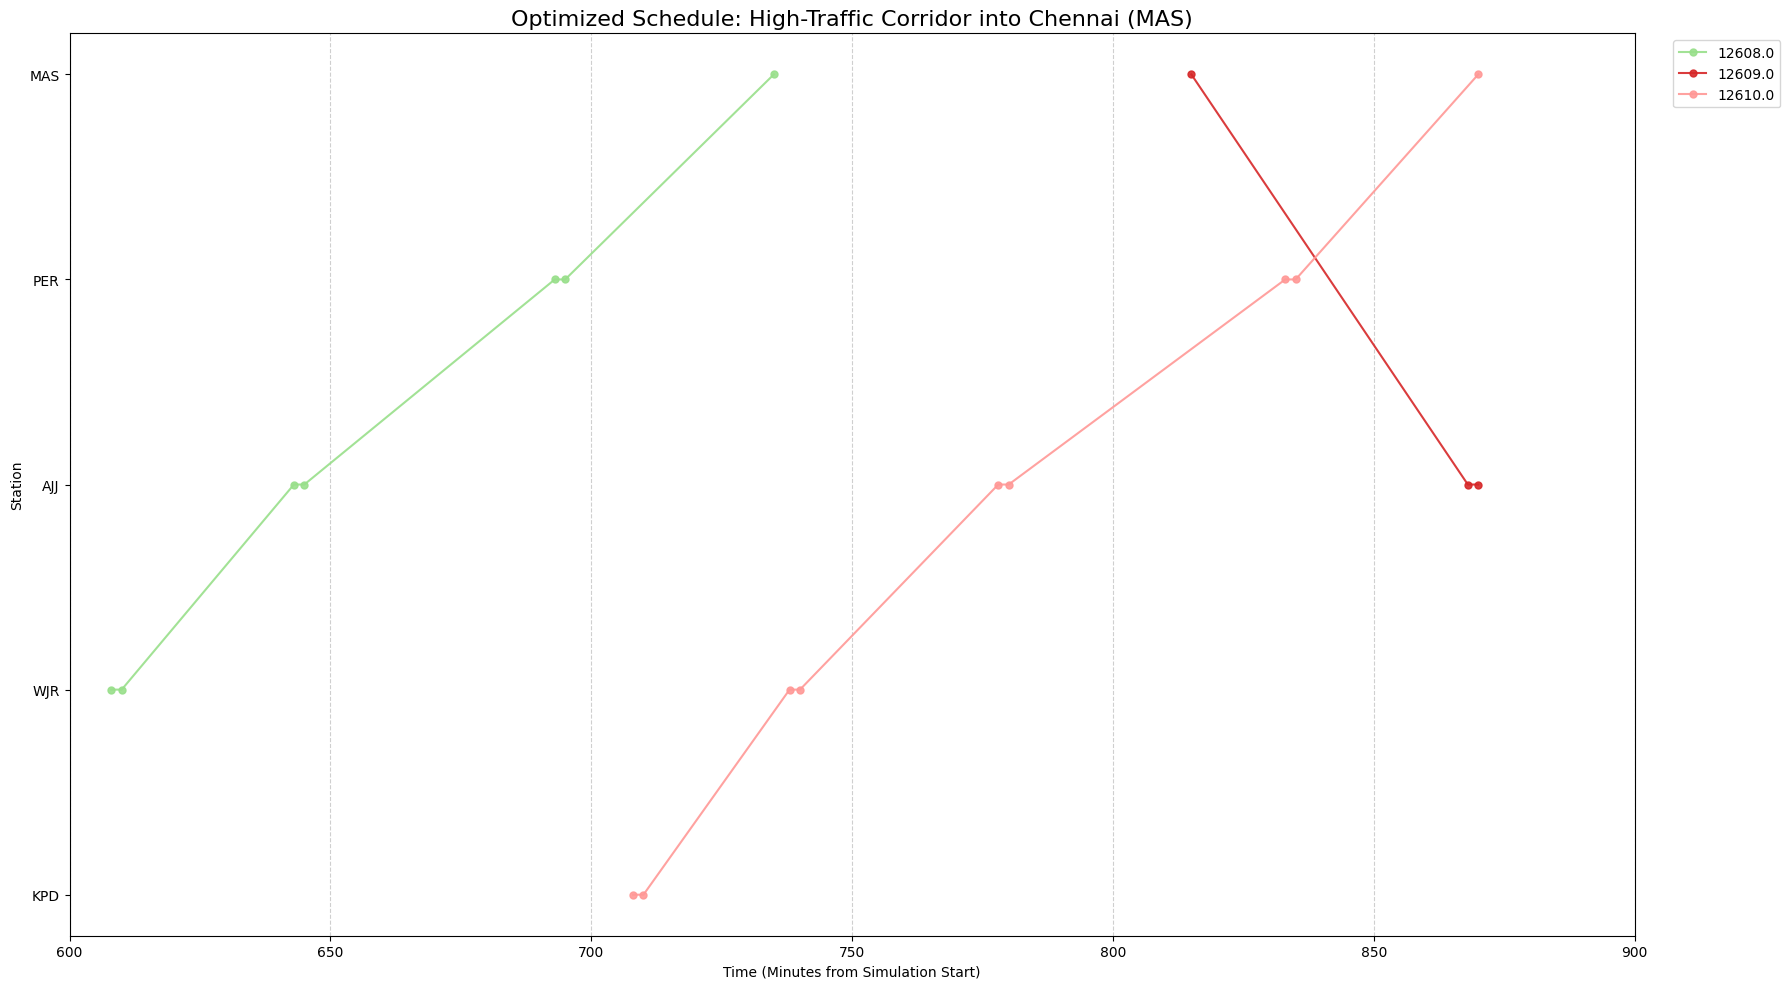

In [13]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --------------------------------------------------------------------------
# 1. HELPER FUNCTIONS & DATA STRUCTURES
# --------------------------------------------------------------------------

def time_to_minutes(time_str):
    """Converts HH:MM:SS to minutes from an epoch to handle multiple days."""
    parts = list(map(int, time_str.split(':')))
    return parts[0] * 60 + parts[1]

class TrainAgent:
    """An agent representing a single train with its own state."""
    def __init__(self, train_id, route_data):
        self.id = train_id
        self.route = self._process_route(route_data)
        self.route_index = 0
        self.status = "AT_STATION"  # AT_STATION or IN_TRANSIT
        self.current_station = self.route[0]['station_code']
        self.departure_time = self.route[0]['departure_time']
        self.arrival_time = 0
        self.is_finished = False

    def _process_route(self, route_data):
        """Processes route times to be cumulative from the start of the simulation."""
        processed_route = []
        last_departure = -1
        day_offset = 0

        # Sort by original departure time to process correctly
        sorted_route = sorted(route_data, key=lambda x: time_to_minutes(x['departure_time']))

        base_departure = time_to_minutes(sorted_route[0]['departure_time'])

        for stop in sorted_route:
            arrival = time_to_minutes(stop['arrival_time'])
            departure = time_to_minutes(stop['departure_time'])

            # Simple day offset logic based on chronological order
            if arrival < last_departure and last_departure != -1:
                day_offset += 1440

            processed_route.append({
                "station_code": stop['station_code'],
                "arrival_time": arrival + day_offset,
                "departure_time": departure + day_offset
            })
            last_departure = departure
        return processed_route

    def log_path(self, time, station):
        """Records the train's position at a given time for later plotting."""
        if not hasattr(self, 'path_log'):
            self.path_log = []
        self.path_log.append({'time': time, 'station': station})

# --------------------------------------------------------------------------
# 2. THE SIMULATION ENGINE
# --------------------------------------------------------------------------

class TrainSimulation:
    def __init__(self, train_data):
        print("Initializing agent-based simulation...")
        self.agents = [TrainAgent(tid, data['route']) for tid, data in train_data.items()]
        self.track_occupancy = {}  # Key: (stn1, stn2), Value: train_id occupying it
        self.master_clock = -1
        print(f"✅ {len(self.agents)} train agents created.")

    def run(self):
        """Runs the entire simulation from start to finish."""
        if not self.agents:
            print("No agents to simulate.")
            return {}

        self.master_clock = min(agent.route[0]['departure_time'] for agent in self.agents)
        print(f"Simulation starting at time: {self.master_clock} minutes.")

        while not self._all_agents_finished():
            for agent in self.agents:
                if agent.is_finished:
                    continue

                # --- Handle arrival logic ---
                if agent.status == "IN_TRANSIT" and self.master_clock >= agent.arrival_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    agent.log_path(self.master_clock, next_stop_info['station_code'])
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))
                    if self.track_occupancy.get(track) == agent.id:
                        del self.track_occupancy[track]

                    agent.route_index += 1
                    agent.status = "AT_STATION"
                    agent.current_station = next_stop_info['station_code']

                    if agent.route_index == len(agent.route) - 1:
                        agent.is_finished = True
                        continue

                    agent.departure_time = agent.route[agent.route_index]['departure_time']

                # --- Handle departure logic ---
                if agent.status == "AT_STATION" and self.master_clock >= agent.departure_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))

                    if track not in self.track_occupancy:
                        self.track_occupancy[track] = agent.id
                        agent.status = "IN_TRANSIT"
                        agent.arrival_time = self.master_clock + (next_stop_info['arrival_time'] - agent.departure_time)
                        agent.log_path(self.master_clock, agent.current_station)
                    else:
                        agent.departure_time += 1

            self.master_clock += 1
            if self.master_clock % 1440 == 0:
                print(f"  ... Day {self.master_clock // 1440} of simulation complete.")

        print("✅ Simulation finished.")
        return self._collect_results()

    def _all_agents_finished(self):
        return all(agent.is_finished for agent in self.agents)

    def _collect_results(self):
        results = {}
        for agent in self.agents:
            original_end_time = agent.route[-1]['arrival_time']
            actual_end_time = agent.arrival_time
            delay = actual_end_time - original_end_time
            print(f"Train {agent.id}: Final arrival (Total Delay: {delay} mins)")
            results[agent.id] = agent.path_log
        return results

# --------------------------------------------------------------------------
# 3. FOCUSED VISUALIZATION FOR PRESENTATION
# --------------------------------------------------------------------------

def plot_zoomed_gantt(schedule_data, title, stations_to_show, time_window):
    """
    Plots a focused Gantt chart for a specific set of stations and a time window.
    """
    fig, ax = plt.subplots(figsize=(20, 10))

    trains_in_section = {}
    for train_id, path_log in schedule_data.items():
        if any(p['station'] in stations_to_show for p in path_log):
            trains_in_section[train_id] = path_log

    station_y_coords = {station: i for i, station in enumerate(stations_to_show)}
    colors = plt.cm.get_cmap('tab20', len(trains_in_section))
    train_colors = {train_id: colors(i) for i, train_id in enumerate(trains_in_section.keys())}

    for train_id, path_log in trains_in_section.items():
        clean_times, clean_stations = [], []
        for p in path_log:
            if time_window[0] <= p['time'] <= time_window[1] and p['station'] in stations_to_show:
                clean_times.append(p['time'])
                clean_stations.append(station_y_coords.get(p['station']))

        if len(clean_times) > 1:
            ax.plot(clean_times, clean_stations, color=train_colors.get(train_id, 'gray'), alpha=0.9, marker='o', markersize=5, linestyle='-', label=train_id)

    ax.set_yticks(range(len(stations_to_show)))
    ax.set_yticklabels(stations_to_show)
    ax.set_xlabel("Time (Minutes from Simulation Start)")
    ax.set_ylabel("Station")
    ax.set_title(title, fontsize=16)
    ax.set_xlim(time_window)
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

    # Create a legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# --------------------------------------------------------------------------
# 4. MAIN EXECUTION BLOCK
# --------------------------------------------------------------------------

if __name__ == "__main__":
    # Step 1: Load the train data from the JSON file
    with open('trains_schedule.json', 'r') as f:
        train_data = json.load(f)

    # Step 2: Create and run the simulation
    simulation = TrainSimulation(train_data)
    optimized_schedule = simulation.run()

    # Step 3: Visualize the results with the new, focused Gantt chart
    print("\n--- Plotting Presentation-Ready Results ---")
    if optimized_schedule:
        # Define a congested section and time window to focus on for the presentation
        congested_stations = ["KPD", "WJR", "AJJ", "PER", "MAS"] # A busy corridor into Chennai
        focus_time = (600, 900) # Focus on a 5-hour window (e.g., 10 AM to 3 PM)

        print("Displaying Zoomed-In Optimized Schedule Chart for the Chennai Corridor...")
        plot_zoomed_gantt(
            optimized_schedule,
            "Optimized Schedule: High-Traffic Corridor into Chennai (MAS)",
            congested_stations,
            focus_time
        )
    else:
        print("Simulation did not produce a schedule to plot.")

In [14]:
pip install Pillow

Initializing agent-based simulation...
✅ 40 train agents created.
Simulation starting at time: 0 minutes.
✅ Simulation finished.

--- Generating Animation ---
Preparing data for animation...


/tmp/ipython-input-1088391594.py:165: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(schedule_data.keys()))


Generating animation (201 frames)... This may take a few minutes.


KeyboardInterrupt: 

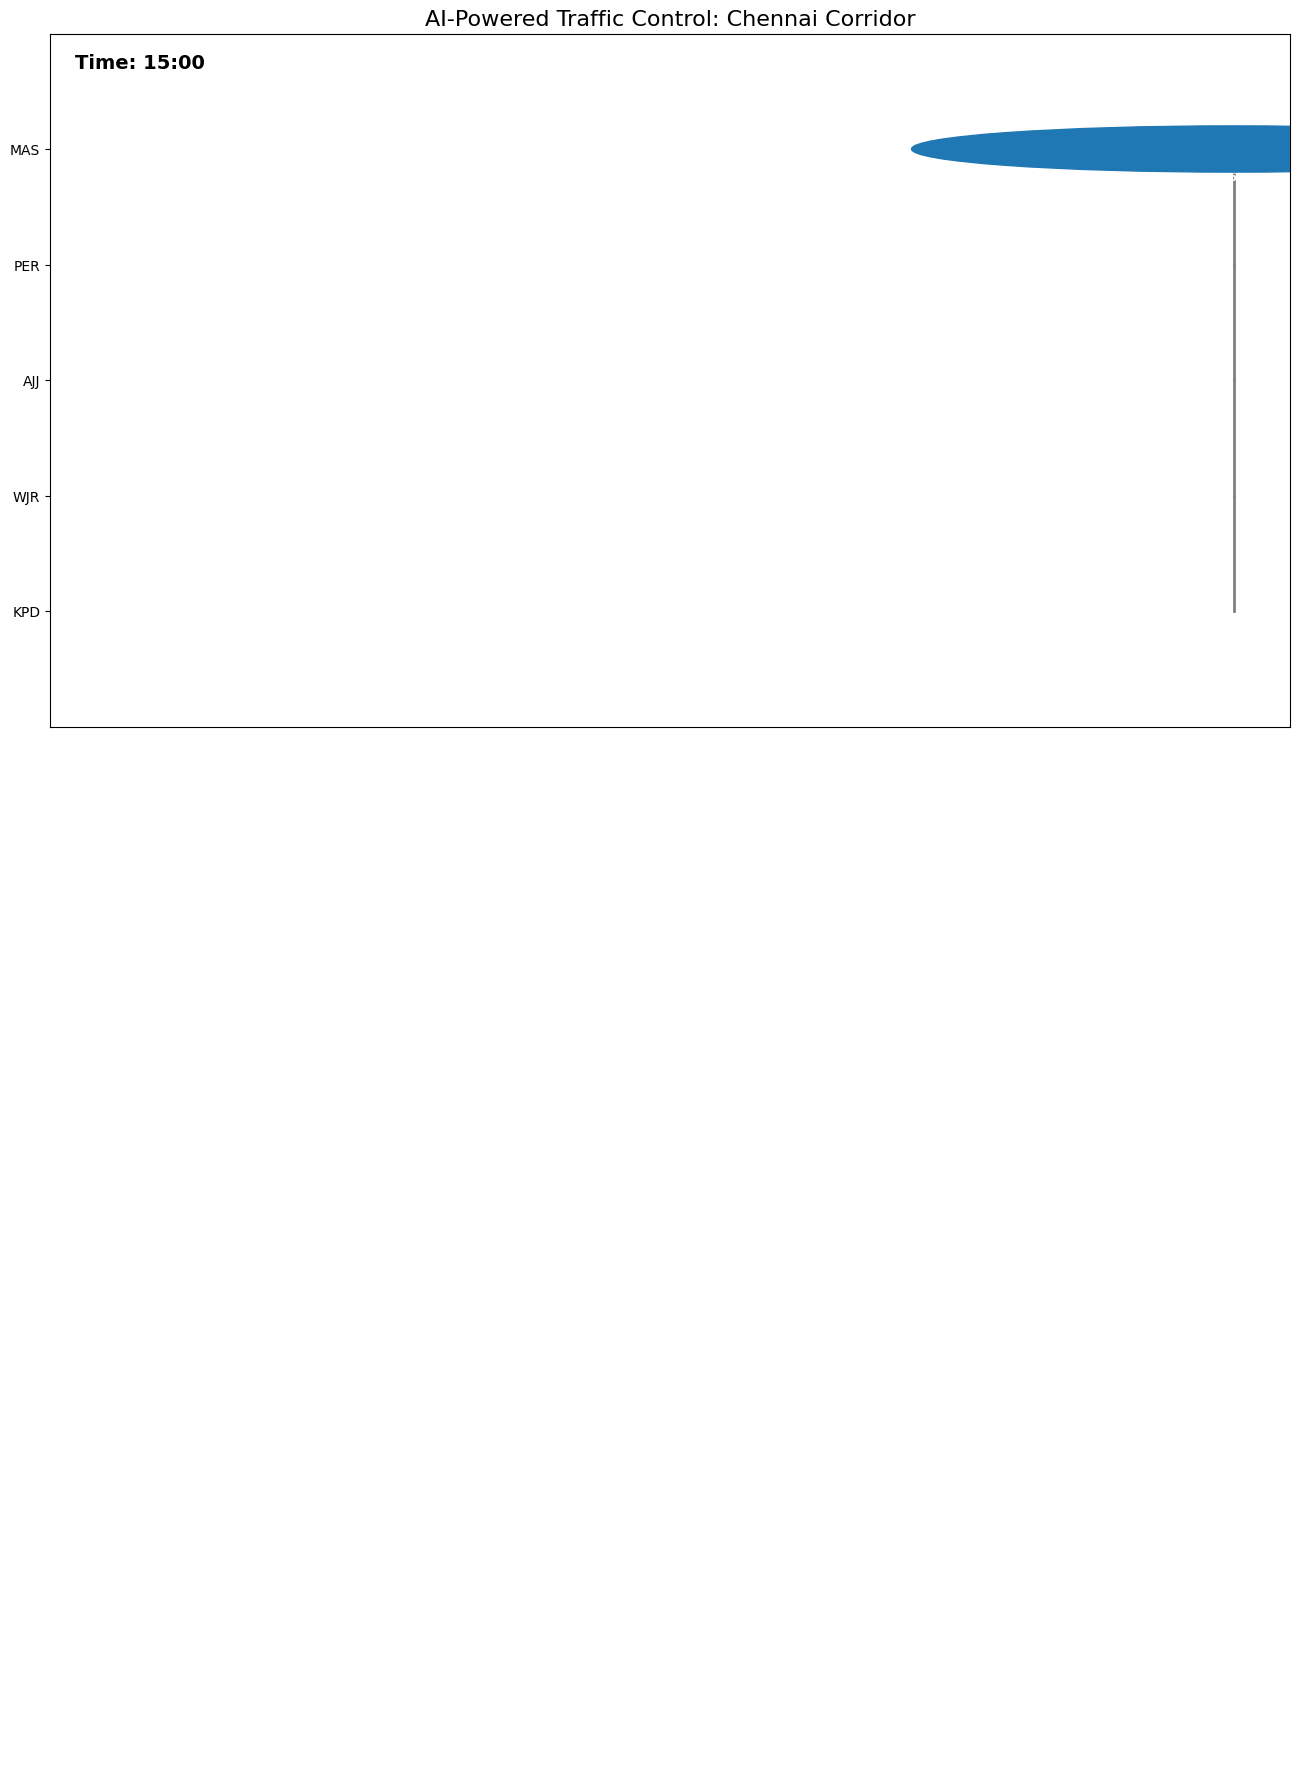

In [15]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation

# --------------------------------------------------------------------------
# 1. HELPER FUNCTIONS & DATA STRUCTURES (No changes from previous version)
# --------------------------------------------------------------------------
def time_to_minutes(time_str):
    parts = list(map(int, time_str.split(':')))
    return parts[0] * 60 + parts[1]

def minutes_to_time_str(minutes):
    if minutes is None: return "N/A"
    minutes = int(minutes)
    h = (minutes // 60) % 24
    m = minutes % 60
    return f"{h:02d}:{m:02d}"

class TrainAgent:
    def __init__(self, train_id, route_data):
        self.id = train_id
        self.route = self._process_route(route_data)
        self.route_index = 0
        self.status = "AT_STATION"
        self.current_station = self.route[0]['station_code']
        self.departure_time = self.route[0]['departure_time']
        self.arrival_time = 0
        self.is_finished = False

    def _process_route(self, route_data):
        processed_route = []
        last_departure = -1
        day_offset = 0
        sorted_route = sorted(route_data, key=lambda x: time_to_minutes(x['departure_time']))
        for stop in sorted_route:
            arrival = time_to_minutes(stop['arrival_time'])
            departure = time_to_minutes(stop['departure_time'])
            if arrival < last_departure and last_departure != -1:
                day_offset += 1440
            processed_route.append({
                "station_code": stop['station_code'],
                "arrival_time": arrival + day_offset,
                "departure_time": departure + day_offset
            })
            last_departure = departure
        return processed_route

    def log_path(self, time, station):
        if not hasattr(self, 'path_log'):
            self.path_log = []
        self.path_log.append({'time': time, 'station': station})

# --------------------------------------------------------------------------
# 2. THE SIMULATION ENGINE (No changes from previous version)
# --------------------------------------------------------------------------
class TrainSimulation:
    def __init__(self, train_data):
        print("Initializing agent-based simulation...")
        self.agents = [TrainAgent(tid, data['route']) for tid, data in train_data.items()]
        self.track_occupancy = {}
        self.master_clock = -1
        print(f"✅ {len(self.agents)} train agents created.")

    def run(self):
        if not self.agents: return {}
        self.master_clock = min(agent.route[0]['departure_time'] for agent in self.agents)
        print(f"Simulation starting at time: {self.master_clock} minutes.")

        while not self._all_agents_finished():
            for agent in self.agents:
                if agent.is_finished: continue

                if agent.status == "IN_TRANSIT" and self.master_clock >= agent.arrival_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    agent.log_path(self.master_clock, next_stop_info['station_code'])
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))
                    if self.track_occupancy.get(track) == agent.id:
                        del self.track_occupancy[track]
                    agent.route_index += 1
                    agent.status = "AT_STATION"
                    agent.current_station = next_stop_info['station_code']
                    if agent.route_index == len(agent.route) - 1:
                        agent.is_finished = True
                        continue
                    agent.departure_time = agent.route[agent.route_index]['departure_time']

                if agent.status == "AT_STATION" and self.master_clock >= agent.departure_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))
                    if track not in self.track_occupancy:
                        self.track_occupancy[track] = agent.id
                        agent.status = "IN_TRANSIT"
                        agent.arrival_time = self.master_clock + (next_stop_info['arrival_time'] - agent.departure_time)
                        agent.log_path(self.master_clock, agent.current_station)
                    else:
                        agent.departure_time += 1
            self.master_clock += 1

        print("✅ Simulation finished.")
        return self._collect_results()

    def _all_agents_finished(self):
        return all(agent.is_finished for agent in self.agents)

    def _collect_results(self):
        results = {}
        for agent in self.agents:
            results[agent.id] = agent.path_log
        return results

# --------------------------------------------------------------------------
# 3. ANIMATION GENERATION
# --------------------------------------------------------------------------

def create_animation_data(schedule_data, stations_to_show):
    """Interpolates train positions for every minute of the simulation."""
    animation_data = {}
    for train_id, path_log in schedule_data.items():
        for i in range(len(path_log) - 1):
            start = path_log[i]
            end = path_log[i+1]

            start_station, end_station = start['station'], end['station']
            start_time, end_time = start['time'], end['time']

            # Skip if segment is outside the focus stations
            if start_station not in stations_to_show or end_station not in stations_to_show:
                continue

            # Handle waiting at a station
            if start_station == end_station:
                for t in range(start_time, end_time + 1):
                    if t not in animation_data: animation_data[t] = []
                    animation_data[t].append({'id': train_id, 'station': start_station, 'status': 'WAITING'})
            # Handle moving between stations
            else:
                duration = end_time - start_time
                for t in range(start_time, end_time + 1):
                    if t not in animation_data: animation_data[t] = []
                    progress = (t - start_time) / duration if duration > 0 else 1
                    animation_data[t].append({'id': train_id, 'from': start_station, 'to': end_station, 'progress': progress, 'status': 'MOVING'})
    return animation_data

def create_simulation_animation(schedule_data, title, stations_to_show, time_window, filename="train_animation.gif"):
    """Creates and saves a GIF animation of the train simulation."""
    print("Preparing data for animation...")
    animation_data = create_animation_data(schedule_data, stations_to_show)
    fig, ax = plt.subplots(figsize=(16, 9))

    # --- Setup the static background of the map ---
    station_y_coords = {station: i for i, station in enumerate(stations_to_show)}
    ax.set_yticks(range(len(stations_to_show)))
    ax.set_yticklabels(stations_to_show)
    ax.set_ylim(-1, len(stations_to_show))
    ax.set_xticks([])
    ax.set_title(title, fontsize=16)

    # Draw tracks
    for i in range(len(stations_to_show) - 1):
        ax.plot([0.5, 0.5], [i, i+1], color='gray', linestyle='-', linewidth=2, zorder=1)

    # --- Setup the animation elements ---
    train_artists = {}
    colors = plt.cm.get_cmap('tab10', len(schedule_data.keys()))
    train_colors = {train_id: colors(i) for i, train_id in enumerate(schedule_data.keys())}

    # Create a circle and a label for each train
    for train_id in schedule_data.keys():
        circle = plt.Circle((0, -10), 0.2, color=train_colors.get(train_id), zorder=5)
        label = ax.text(0, -10, train_id.split('.')[0], ha='center', va='bottom', fontsize=9, color='white', weight='bold')
        ax.add_patch(circle)
        train_artists[train_id] = (circle, label)

    clock_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=14, weight='bold')

    # --- Animation update function ---
    def update(frame):
        time_data = animation_data.get(frame, [])
        active_trains = set()

        for train_data in time_data:
            train_id = train_data['id']
            active_trains.add(train_id)
            circle, label = train_artists[train_id]

            if train_data['status'] == 'WAITING':
                y_pos = station_y_coords[train_data['station']]
                circle.center = (0.5, y_pos)
            else: # Moving
                y_start = station_y_coords[train_data['from']]
                y_end = station_y_coords[train_data['to']]
                y_pos = y_start + (y_end - y_start) * train_data['progress']
                circle.center = (0.5, y_pos)

            label.set_position((circle.center[0], circle.center[1] - 0.3))

        # Hide trains that are not active in this frame
        for train_id, (circle, label) in train_artists.items():
            if train_id not in active_trains:
                circle.center = (0, -10) # Move off-screen
                label.set_position((0, -10))

        clock_text.set_text(f"Time: {minutes_to_time_str(frame)}")
        return list(artist for artist_tuple in train_artists.values() for artist in artist_tuple) + [clock_text]

    # --- Create and save the animation ---
    start_time, end_time = time_window
    frames = range(start_time, end_time + 1)

    print(f"Generating animation ({len(frames)} frames)... This may take a few minutes.")
    ani = FuncAnimation(fig, update, frames=frames, interval=50, blit=True)

    try:
        ani.save(filename, writer='pillow')
        print(f"✅ Animation saved successfully as '{filename}'")
    except Exception as e:
        print(f"❌ Error saving animation: {e}")
        print("Please ensure you have 'Pillow' installed (`pip install Pillow`)")

# --------------------------------------------------------------------------
# 5. MAIN EXECUTION BLOCK
# --------------------------------------------------------------------------
if __name__ == "__main__":
    with open('trains_schedule.json', 'r') as f:
        train_data = json.load(f)

    simulation = TrainSimulation(train_data)
    optimized_schedule = simulation.run()

    print("\n--- Generating Animation ---")
    if optimized_schedule:
        congested_stations = ["KPD", "WJR", "AJJ", "PER", "MAS"]
        focus_time = (700, 900) # A 3hr+ window to see the interactions

        create_simulation_animation(
            optimized_schedule,
            "AI-Powered Traffic Control: Chennai Corridor",
            congested_stations,
            focus_time,
            filename="train_simulation.gif"
        )
    else:
        print("Simulation did not produce a schedule to animate.")

Initializing agent-based simulation...
✅ 40 train agents created.
Simulation starting at time: 0 minutes.
✅ Simulation finished.

--- Generating Presentation Animation ---
Preparing data for smooth animation...


/tmp/ipython-input-2261820958.py:171: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(interpolated_paths.keys()))


Generating smooth animation (301 frames)... This may take a few minutes.
✅ Animation saved successfully as 'train_simulation_smooth.gif'


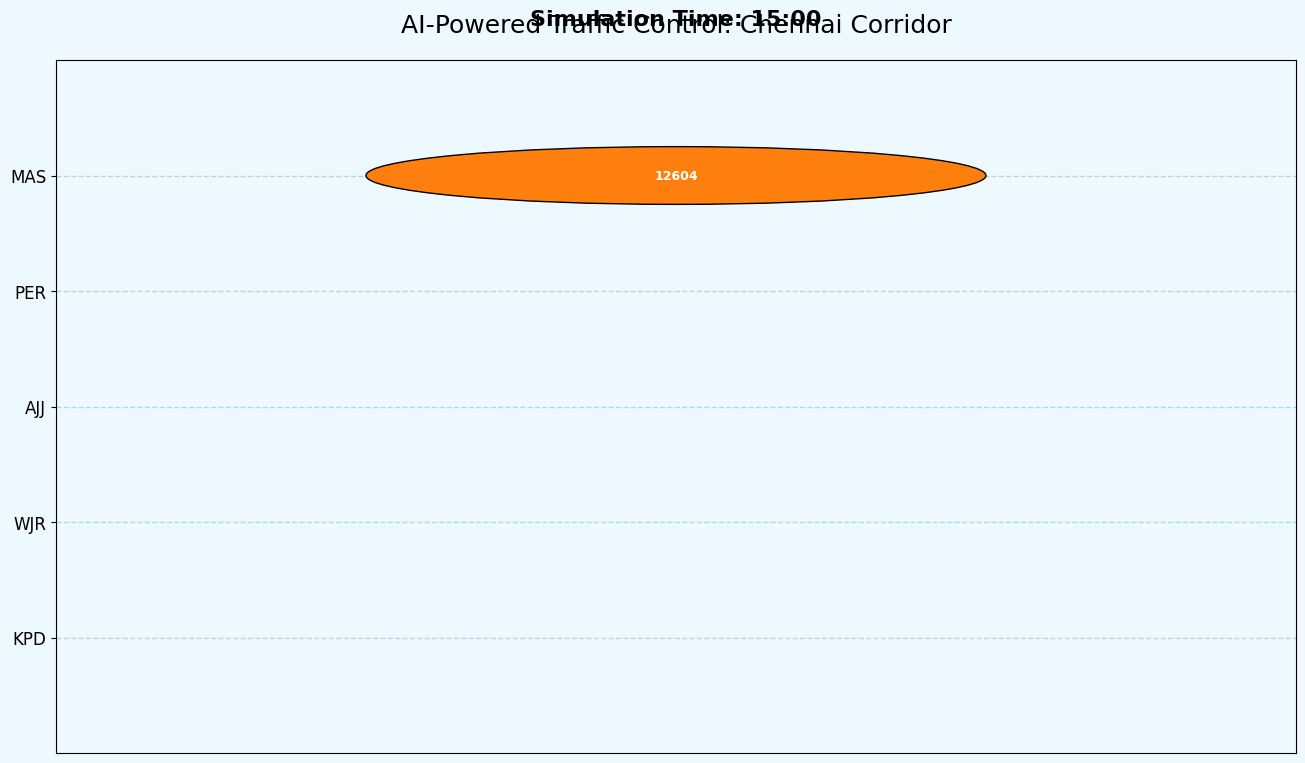

In [16]:
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --------------------------------------------------------------------------
# 1. HELPER FUNCTIONS & DATA STRUCTURES (No changes)
# --------------------------------------------------------------------------
def time_to_minutes(time_str):
    parts = list(map(int, time_str.split(':')))
    return parts[0] * 60 + parts[1]

def minutes_to_time_str(minutes):
    if minutes is None: return "N/A"
    minutes = int(minutes)
    h = (minutes // 60) % 24
    m = minutes % 60
    return f"{h:02d}:{m:02d}"

class TrainAgent:
    def __init__(self, train_id, route_data):
        self.id = train_id
        self.route = self._process_route(route_data)
        self.route_index = 0
        self.status = "AT_STATION"
        self.current_station = self.route[0]['station_code']
        self.departure_time = self.route[0]['departure_time']
        self.arrival_time = 0
        self.is_finished = False

    def _process_route(self, route_data):
        processed_route = []
        last_departure = -1
        day_offset = 0
        sorted_route = sorted(route_data, key=lambda x: time_to_minutes(x['departure_time']))
        for stop in sorted_route:
            arrival = time_to_minutes(stop['arrival_time'])
            departure = time_to_minutes(stop['departure_time'])
            if arrival < last_departure and last_departure != -1:
                day_offset += 1440
            processed_route.append({
                "station_code": stop['station_code'],
                "arrival_time": arrival + day_offset,
                "departure_time": departure + day_offset
            })
            last_departure = departure
        return processed_route

    def log_path(self, time, station):
        if not hasattr(self, 'path_log'):
            self.path_log = []
        self.path_log.append({'time': time, 'station': station})

# --------------------------------------------------------------------------
# 2. THE SIMULATION ENGINE (No changes)
# --------------------------------------------------------------------------
class TrainSimulation:
    def __init__(self, train_data):
        print("Initializing agent-based simulation...")
        self.agents = [TrainAgent(tid, data['route']) for tid, data in train_data.items()]
        self.track_occupancy = {}
        self.master_clock = -1
        print(f"✅ {len(self.agents)} train agents created.")

    def run(self):
        if not self.agents: return {}
        self.master_clock = min(agent.route[0]['departure_time'] for agent in self.agents)
        print(f"Simulation starting at time: {self.master_clock} minutes.")

        while not self._all_agents_finished():
            for agent in self.agents:
                if agent.is_finished: continue

                if agent.status == "IN_TRANSIT" and self.master_clock >= agent.arrival_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    agent.log_path(self.master_clock, next_stop_info['station_code'])
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))
                    if self.track_occupancy.get(track) == agent.id:
                        del self.track_occupancy[track]
                    agent.route_index += 1
                    agent.status = "AT_STATION"
                    agent.current_station = next_stop_info['station_code']
                    if agent.route_index == len(agent.route) - 1:
                        agent.is_finished = True
                        continue
                    agent.departure_time = agent.route[agent.route_index]['departure_time']

                if agent.status == "AT_STATION" and self.master_clock >= agent.departure_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))
                    if track not in self.track_occupancy:
                        self.track_occupancy[track] = agent.id
                        agent.status = "IN_TRANSIT"
                        agent.arrival_time = self.master_clock + (next_stop_info['arrival_time'] - agent.departure_time)
                        agent.log_path(self.master_clock, agent.current_station)
                    else:
                        agent.departure_time += 1
            self.master_clock += 1

        print("✅ Simulation finished.")
        return self._collect_results()

    def _all_agents_finished(self):
        return all(agent.is_finished for agent in self.agents)

    def _collect_results(self):
        results = {}
        for agent in self.agents:
            results[agent.id] = agent.path_log
        return results

# --------------------------------------------------------------------------
# 3. **REVISED** ANIMATION GENERATION
# --------------------------------------------------------------------------

def create_animation_data(schedule_data, stations_to_show):
    """
    Interpolates train positions for every minute, ensuring smooth paths.
    """
    interpolated_paths = {}

    # First, identify trains that appear in the station list
    relevant_trains = {
        train_id: path_log for train_id, path_log in schedule_data.items()
        if any(p['station'] in stations_to_show for p in path_log)
    }

    station_y_coords = {station: i for i, station in enumerate(stations_to_show)}

    for train_id, path_log in relevant_trains.items():
        interpolated_paths[train_id] = {}
        for i in range(len(path_log) - 1):
            start, end = path_log[i], path_log[i+1]
            start_time, end_time = start['time'], end['time']

            # Get y-coordinates, which might be outside the visible range
            y_start = station_y_coords.get(start['station'])
            y_end = station_y_coords.get(end['station'])

            # Handle waiting at a station
            if start['station'] == end['station'] and y_start is not None:
                for t in range(start_time, end_time + 1):
                    interpolated_paths[train_id][t] = {'y': y_start, 'status': 'WAITING'}
            # Handle moving between stations
            elif y_start is not None and y_end is not None:
                duration = end_time - start_time
                for t in range(start_time, end_time + 1):
                    progress = (t - start_time) / duration if duration > 0 else 1
                    y_pos = y_start + (y_end - y_start) * progress
                    interpolated_paths[train_id][t] = {'y': y_pos, 'status': 'MOVING'}

    return interpolated_paths

def create_simulation_animation(schedule_data, title, stations_to_show, time_window, filename="train_animation_smooth.gif"):
    """Creates and saves a smooth GIF animation of the train simulation."""
    print("Preparing data for smooth animation...")
    interpolated_paths = create_animation_data(schedule_data, stations_to_show)
    fig, ax = plt.subplots(figsize=(16, 9))

    ax.set_yticks(range(len(stations_to_show)))
    ax.set_yticklabels(stations_to_show, fontsize=12)
    ax.set_ylim(-1, len(stations_to_show))
    ax.set_xticks([])
    ax.set_title(title, fontsize=18, pad=20)
    ax.set_facecolor("#eef9ff") # Light blue background
    fig.set_facecolor("#eef9ff")

    for i in range(len(stations_to_show)):
        ax.axhline(i, color='lightblue', linestyle='--', linewidth=1, zorder=1)

    train_artists = {}
    colors = plt.cm.get_cmap('tab10', len(interpolated_paths.keys()))
    train_colors = {train_id: colors(i) for i, train_id in enumerate(interpolated_paths.keys())}

    for train_id in interpolated_paths.keys():
        circle = plt.Circle((-1, -1), 0.25, color=train_colors.get(train_id), zorder=5, ec='black')
        label = ax.text(-1, -1, train_id.split('.')[0], ha='center', va='center', fontsize=9, color='white', weight='bold', zorder=6)
        ax.add_patch(circle)
        train_artists[train_id] = (circle, label)

    clock_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center', fontsize=16, weight='bold')

    def update(frame):
        for train_id, (circle, label) in train_artists.items():
            pos_data = interpolated_paths[train_id].get(frame)
            if pos_data:
                y_pos = pos_data['y']
                circle.center = (0.5, y_pos)
                label.set_position(circle.center)
                circle.set_visible(True)
                label.set_visible(True)
            else:
                circle.set_visible(False)
                label.set_visible(False)

        clock_text.set_text(f"Simulation Time: {minutes_to_time_str(frame)}")
        return list(artist for artist_tuple in train_artists.values() for artist in artist_tuple) + [clock_text]

    start_time, end_time = time_window
    frames = range(start_time, end_time + 1)

    print(f"Generating smooth animation ({len(frames)} frames)... This may take a few minutes.")
    ani = FuncAnimation(fig, update, frames=frames, interval=40, blit=True)

    try:
        ani.save(filename, writer='pillow', fps=25)
        print(f"✅ Animation saved successfully as '{filename}'")
    except Exception as e:
        print(f"❌ Error saving animation: {e}")

# --------------------------------------------------------------------------
# 4. MAIN EXECUTION BLOCK
# --------------------------------------------------------------------------
if __name__ == "__main__":
    with open('trains_schedule.json', 'r') as f:
        train_data = json.load(f)

    simulation = TrainSimulation(train_data)
    optimized_schedule = simulation.run()

    print("\n--- Generating Presentation Animation ---")
    if optimized_schedule:
        # Define the trains and stations you want to feature in the animation
        congested_stations = ["KPD", "WJR", "AJJ", "PER", "MAS"]
        # Define the time window for the animation
        focus_time = (600, 900)

        create_simulation_animation(
            optimized_schedule,
            "AI-Powered Traffic Control: Chennai Corridor",
            congested_stations,
            focus_time,
            filename="train_simulation_smooth.gif"
        )
    else:
        print("Simulation did not produce a schedule to animate.")

In [24]:
pip install plotly pandas

In [25]:
import json
import pandas as pd
import plotly.express as px

# --------------------------------------------------------------------------
# 1. HELPER FUNCTIONS & DATA STRUCTURES (Unchanged)
# --------------------------------------------------------------------------
def time_to_minutes(time_str):
    parts = list(map(int, time_str.split(':')))
    return parts[0] * 60 + parts[1]

def minutes_to_time_str(minutes):
    if minutes is None: return "N/A"
    minutes = int(minutes)
    day = (minutes // 1440) + 1
    h = (minutes % 1440) // 60
    m = minutes % 60
    return f"Day {day}, {h:02d}:{m:02d}"

class TrainAgent:
    def __init__(self, train_id, route_data):
        self.id = train_id
        self.route = self._process_route(route_data)
        self.route_index = 0
        self.status = "AT_STATION"
        self.current_station = self.route[0]['station_code']
        self.departure_time = self.route[0]['departure_time']
        self.arrival_time = 0
        self.is_finished = False

    def _process_route(self, route_data):
        processed_route = []
        last_time = -1
        day_offset = 0
        sorted_route = sorted(route_data, key=lambda x: time_to_minutes(x['departure_time']))
        for stop in sorted_route:
            arrival = time_to_minutes(stop['arrival_time'])
            departure = time_to_minutes(stop['departure_time'])
            if last_time != -1 and arrival < (last_time % 1440) and (last_time % 1440) > 720 and arrival < 720:
                day_offset += 1440
            current_arrival = arrival + day_offset
            if departure < arrival: day_offset += 1440
            current_departure = departure + day_offset
            processed_route.append({
                "station_code": stop['station_code'],
                "arrival_time": current_arrival,
                "departure_time": current_departure
            })
            last_time = max(current_arrival, current_departure)
        return processed_route

    def log_path(self, time, station):
        if not hasattr(self, 'path_log'): self.path_log = []
        self.path_log.append({'time': time, 'station': station})

# --------------------------------------------------------------------------
# 2. THE SIMULATION ENGINE (Unchanged)
# --------------------------------------------------------------------------
class TrainSimulation:
    def __init__(self, train_data):
        print("Initializing agent-based simulation...")
        self.agents = [TrainAgent(tid, data['route']) for tid, data in train_data.items()]
        self.track_occupancy = {}
        self.master_clock = -1
        print(f"✅ {len(self.agents)} train agents created.")

    def run(self):
        if not self.agents: return {}
        self.master_clock = min(agent.route[0]['departure_time'] for agent in self.agents)
        print(f"Simulation starting at time: {self.master_clock} minutes.")
        while not self._all_agents_finished():
            for agent in self.agents:
                if agent.is_finished: continue
                if agent.status == "IN_TRANSIT" and self.master_clock >= agent.arrival_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    agent.log_path(self.master_clock, next_stop_info['station_code'])
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))
                    if self.track_occupancy.get(track) == agent.id:
                        del self.track_occupancy[track]
                    agent.route_index += 1
                    agent.status = "AT_STATION"
                    agent.current_station = next_stop_info['station_code']
                    if agent.route_index == len(agent.route) - 1:
                        agent.is_finished = True; continue
                    agent.departure_time = agent.route[agent.route_index]['departure_time']
                if agent.status == "AT_STATION" and self.master_clock >= agent.departure_time:
                    next_stop_info = agent.route[agent.route_index + 1]
                    track = tuple(sorted((agent.current_station, next_stop_info['station_code'])))
                    if track not in self.track_occupancy:
                        self.track_occupancy[track] = agent.id
                        agent.status = "IN_TRANSIT"
                        agent.arrival_time = self.master_clock + (next_stop_info['arrival_time'] - agent.departure_time)
                        agent.log_path(self.master_clock, agent.current_station)
                    else:
                        agent.departure_time += 1
            self.master_clock += 1
        print("✅ Simulation finished.")
        return self._collect_results()

    def _all_agents_finished(self):
        return all(agent.is_finished for agent in self.agents)

    def _collect_results(self):
        results = {}
        for agent in self.agents: results[agent.id] = agent.path_log
        return results

# --------------------------------------------------------------------------
# 3. **NEW & RELIABLE** ANIMATION WITH PLOTLY
# --------------------------------------------------------------------------
def create_plotly_animation(schedule_data, title, stations_to_show, trains_to_show, time_window, filename="train_animation.html"):
    """Creates a reliable, interactive HTML animation using Plotly."""
    print("Preparing data for Plotly animation...")

    # 1. Convert simulation data into a Pandas DataFrame, the format Plotly loves
    animation_frames = []
    for train_id, path_log in schedule_data.items():
        if train_id not in trains_to_show:
            continue
        for i in range(len(path_log) - 1):
            start, end = path_log[i], path_log[i+1]
            start_time, end_time = start['time'], end['time']
            duration = end_time - start_time
            for t in range(start_time, end_time + 1):
                if time_window[0] <= t <= time_window[1]:
                    progress = (t - start_time) / duration if duration > 0 else 1
                    animation_frames.append({
                        "time": t,
                        "Train ID": train_id.split('.')[0],
                        "From": start['station'],
                        "To": end['station'],
                        "progress": progress
                    })

    df = pd.DataFrame(animation_frames)
    if df.empty:
        print("No data to animate in the specified time window.")
        return

    # Create a mapping for stations to Y-coordinates for plotting
    station_y_coords = {station: i for i, station in enumerate(stations_to_show)}

    # Calculate the Y-position for each frame
    df['y_pos'] = df.apply(
        lambda row: station_y_coords.get(row['From'], -1) +
                    (station_y_coords.get(row['To'], -1) - station_y_coords.get(row['From'], -1)) * row['progress'],
        axis=1
    )
    df['x_pos'] = 0.5 # Keep all trains on a single vertical track line
    df['Time Label'] = df['time'].apply(minutes_to_time_str)

    print("Generating Plotly animation... This will be fast.")

    # 2. Create the animated scatter plot with Plotly Express
    fig = px.scatter(
        df,
        x="x_pos",
        y="y_pos",
        animation_frame="Time Label", # Animate based on the time label
        animation_group="Train ID",   # Keep the same train across frames
        color="Train ID",             # Color trains by their ID
        hover_name="Train ID",        # Show train ID on hover
        text="Train ID",              # Display train ID on the marker
        range_y=[-0.5, len(stations_to_show) - 0.5],
        range_x=[0, 1]
    )

    # 3. Style the animation for a clean, professional look
    fig.update_traces(textposition='middle center', textfont_size=10, textfont_color='white',
                      marker=dict(size=40, line=dict(width=2, color='black')))

    fig.update_layout(
        title=title,
        yaxis=dict(
            tickmode='array',
            tickvals=list(station_y_coords.values()),
            ticktext=list(station_y_coords.keys()),
            title="Station"
        ),
        xaxis=dict(showticklabels=False, title=None, showgrid=False, zeroline=False),
        plot_bgcolor="#eaf4f7",
        legend_title_text='Trains'
    )
    # Slow down the animation speed
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 30

    # 4. Save to an HTML file
    fig.write_html(filename)
    print(f"✅ Animation saved successfully as '{filename}'")

# --------------------------------------------------------------------------
# 4. MAIN EXECUTION BLOCK
# --------------------------------------------------------------------------
if __name__ == "__main__":
    with open('trains_schedule.json', 'r') as f:
        train_data = json.load(f)

    simulation = TrainSimulation(train_data)
    optimized_schedule = simulation.run()

    print("\n--- Generating Presentation Animation ---")
    if optimized_schedule:
        # Define the corridor, trains, and time for your animation story
        congested_stations = ["KPD", "WJR", "AJJ", "PER", "MAS"]
        trains_to_feature = ["12608.0", "12610.0", "12609.0"]
        focus_time = (700, 900)

        create_plotly_animation(
            optimized_schedule,
            "AI-Powered Traffic Control: Chennai Corridor",
            congested_stations,
            trains_to_feature,
            focus_time,
            filename="train_animation.html"
        )
    else:
        print("Simulation did not produce a schedule to animate.")

Initializing agent-based simulation...
✅ 40 train agents created.
Simulation starting at time: 2 minutes.
✅ Simulation finished.

--- Generating Presentation Animation ---
Preparing data for Plotly animation...
Generating Plotly animation... This will be fast.
✅ Animation saved successfully as 'train_animation.html'
